# Análisis predictivo de series temporales

-----

## Predicción en modelos ARMA, modelos ARIMA y resumen.


In [1]:
#install.packages("devtools")     # only need to do this once
#devtools::install_github("nickpoison/astsa")
#install.packages("astsa")
library(astsa)
options(repr.plot.width=15, repr.plot.height=8) #ajusta tamaño de graficas

## Predicción en modelos ARMA

**Idea:** dado un modelo ARMA(p,q) de parámetros $\phi_1,\ldots,\phi_p$ y $\theta_1,\ldots,\theta_q$, y posiblemente una media $\mu$, es decir un proceso:

$$ x_t - \mu = \phi_1 (x_{t-1} - \mu) + \ldots + \phi_p(x_{t-p}-\mu) + w_t + \theta_1 w_{t-1} + \ldots +\theta_q w_{t-q},$$

¿Cuál es la mejor predicción que uno puede hacer de $x_{t+n}$ conociendo los valores del proceso $x_0,\ldots,x_t$ y los parámetros?

### El caso AR(p)

Supongamos $\mu=0$ (en otro caso hay que considerar los desvíos a partir de $\mu$). Este caso ya lo discutimos, si conocemos el proceso hasta tiempo $n$, entonces sabemos que:

$$x_{n+1} = \phi_1 x_n +\ldots + \phi_p x_{n-p+1} + w_{n+1},$$

El mejor predictor $\hat{x}_{n+1}^n$ en términos de error cuadrático medio es un predictor lineal:

$$\hat{x}_{n+1}^n = \alpha_0 + \sum_{k=1}^n \alpha_k x_k,$$

que debe satisfacer las *ecuaciones de predicción*:

$$E[(x_{n+1} - \hat{x}_{n+1}^n)x_k]=0 \quad \forall k=0,\ldots,n,$$

es decir, el error de predicción no debe estar correlacionado con ninguna de las muestras anteriores (extrajimos "toda la información").

Notemos que es muy fácil resolver esto en el caso del $AR(p)$ ya que tomando como predicción:

$$\hat{x}^n_{n+1} = \phi_1 x_n +\ldots + \phi_p x_{n-p+1},$$

se tiene que $x_{n+1} - \hat{x}^n_{n+1} = w_{n+1}$ que sabemos no está correlacionado con ninguna muestra anterior!

Es decir, simplemente propagando la recursión como si el ruido fuera $0$ obtenemos una predicción (hay que demostrar esto para $n+2$, $n+3$, etc.)


### El caso ARMA(p,q)

En el caso general no resulta tan sencillo resolver las ecuaciones de predicción, y debemos usar toda la historia del proceso. Consideremos el caso de predicción a un paso:

Construyo un estimador:

$$\hat{x}^n_{n+1} = \phi_{n1}x_n + \ldots +\phi_{nn}x_1 = \phi_n^T x$$

siendo $x=(x_1,\ldots,x_n)$ el vector con todos los valores anteriores.

Planteando la ecuación de predicción queda:

$$E[(x_{n+1} - \sum_{j=1}^n \phi_{nj}x_{n+1-j})x_{n+1-k}] = 0, \quad k=1,\ldots,n.$$

Haciendo la distributiva queda:

$$E[x_{n+1}x_{n+1-k}] =  \sum_{j=1}^n \phi_{nj}E[x_{n+1-j}x_{n+1-k}] = 0, \quad k=1,\ldots,n.$$

Identificando las covarianzas nos queda el siguiente sistema de ecuaciones:

$$\gamma(k) =  \sum_{j=1}^n \phi_{nj}\gamma(k-j) = 0, \quad k=1,\ldots,n.$$

Lo anterior es un sistema de ecuaciones de la forma:

$$\Gamma_n \phi_n = \gamma_n.$$

Resolviendo el sistema salen los coefincientes.

**Nota:** debemos tener calculadas las covarianzas del modelo!

También se puede calcular la *varianza* del error de predicción para hacer intervalos de confianza, y queda:

$$P_{n+1}^n = \gamma(0) - \gamma_n^T \Gamma_n^{-1} \gamma_n.$$

### Problema

La ecuación anterior solo explica como calcular "el paso siguiente" y aún así es muy difícil de resolver si el conjunto de datos es grande (sistema lineal grande). Afortunadamente ambos incovenientes se pueden levantar usando métodos recursivos:

* Algoritmo de Durbin-Levinson.
* Algoritmo de innovaciones.

Estos son los algoritmos que usan las bibliotecas de R para predecir. En particular, calculan:

* El mejor predictor lineal $\hat{x}_{n+m}^n$ $m$ muestras adelante.
* La varianza $P^n_{n+m}$ del error, lo que permite construir intervaos de confianza.

In [6]:
### Ejemplo, ajustamos un AR(2) a la serie de recruitement

fit = arima(rec,order = c(2,0,0), include.mean=TRUE)
fit


Call:
arima(x = rec, order = c(2, 0, 0), include.mean = TRUE)

Coefficients:
         ar1      ar2  intercept
      1.3512  -0.4612    61.8585
s.e.  0.0416   0.0417     4.0039

sigma^2 estimated as 89.33:  log likelihood = -1661.51,  aic = 3331.02

In [8]:
fore = predict(regr, n.ahead=24)

fore

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1987,,,,,,,,,,20.30431,25.95348,32.47533
1988,38.68977,44.08379,48.50925,52.00324,54.68456,56.69691,58.17985,59.25576,60.02576,60.57005,60.95041,61.21334
1989,61.39319,61.51494,61.59649,61.65053,61.68592,61.70882,61.72343,61.73261,61.73827,,,
,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
1987,,,,,,,,,,9.471909,15.944071,20.559250
1988,23.623053,25.553103,26.717876,27.394982,27.775564,27.983007,28.092933,28.149685,28.178283,28.192368,28.199157,28.202360
1989,28.203840,28.204510,28.204807,28.204935,28.204990,28.205012,28.205021,28.205025,28.205026,,,


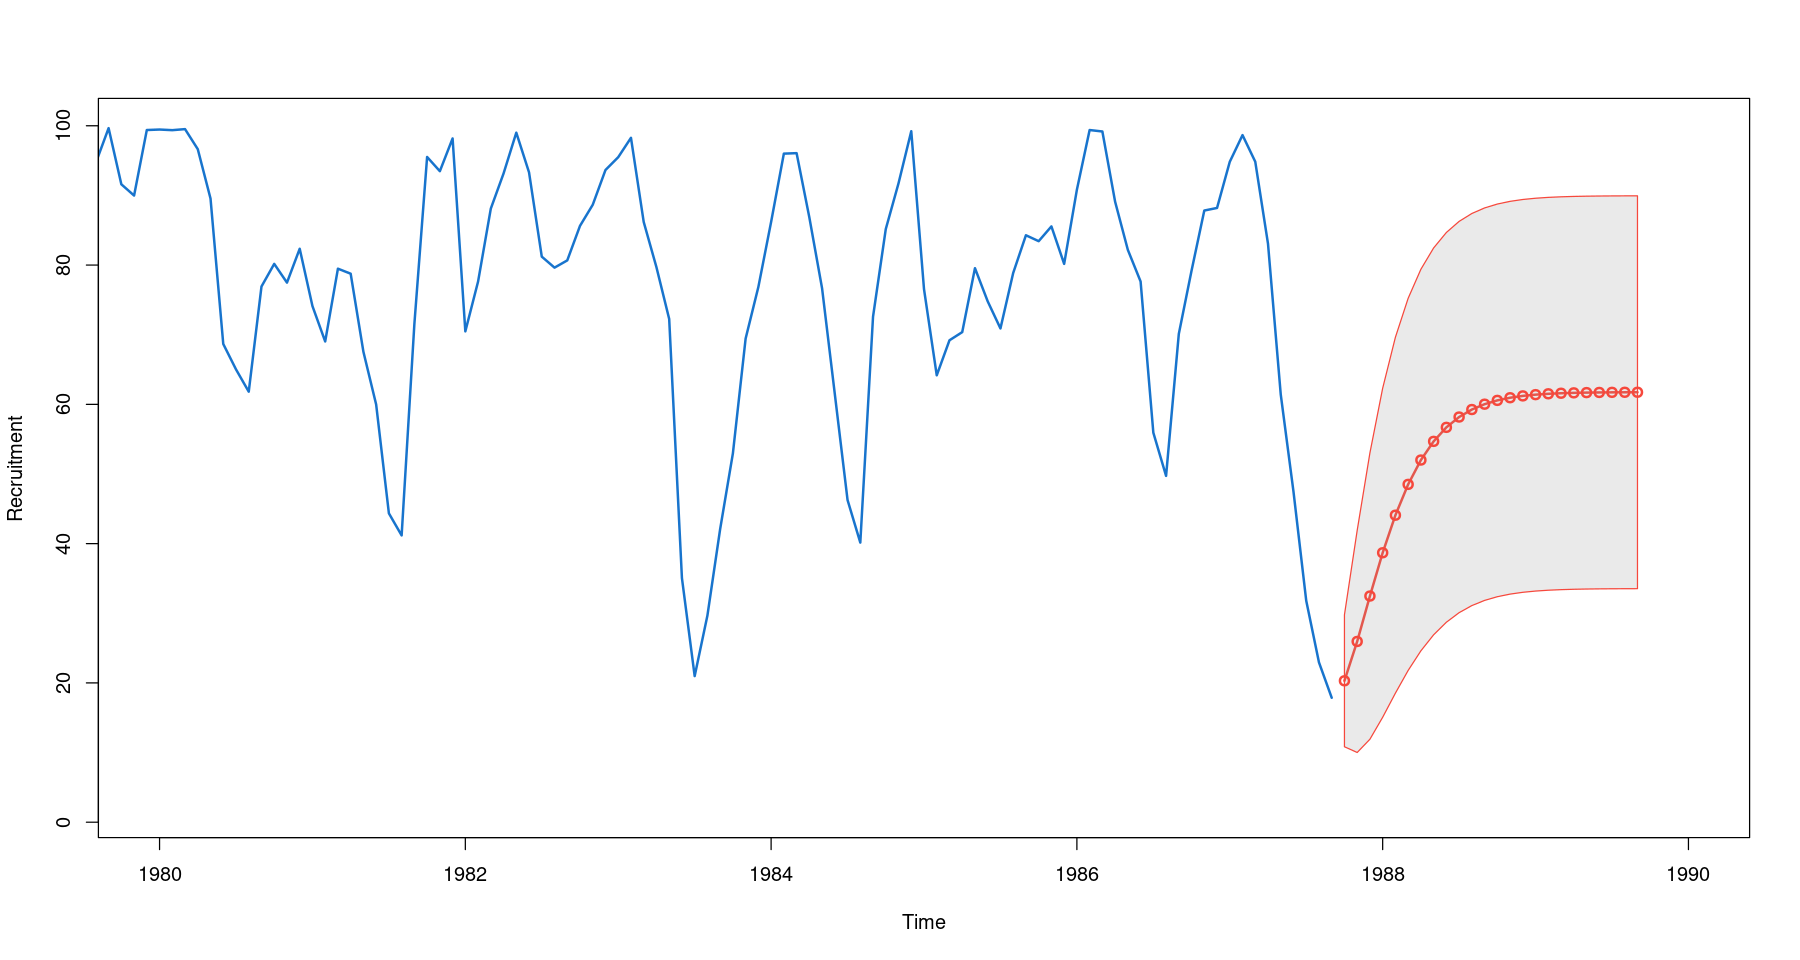

In [21]:
ts.plot(rec, fore$pred, col=c(4,2), lwd=2, xlim=c(1980,1990), ylab="Recruitment")

#Construyo un intervalo de confianza
U = fore$pred+fore$se; L = fore$pred-fore$se
xx = c(time(U), rev(time(U))); yy = c(L, rev(U))

polygon(xx, yy, border = 2, col = gray(.6, alpha = .2))
lines(fore$pred, type="p", col=2, lwd=2)

In [23]:
library(forecast)  # Automatic ARIMA forecasts
fit <- Arima(rec, order=c(2,0,0))
fit

Series: rec 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
         ar1      ar2     mean
      1.3512  -0.4612  61.8585
s.e.  0.0416   0.0417   4.0039

sigma^2 estimated as 89.93:  log likelihood=-1661.51
AIC=3331.02   AICc=3331.11   BIC=3347.48

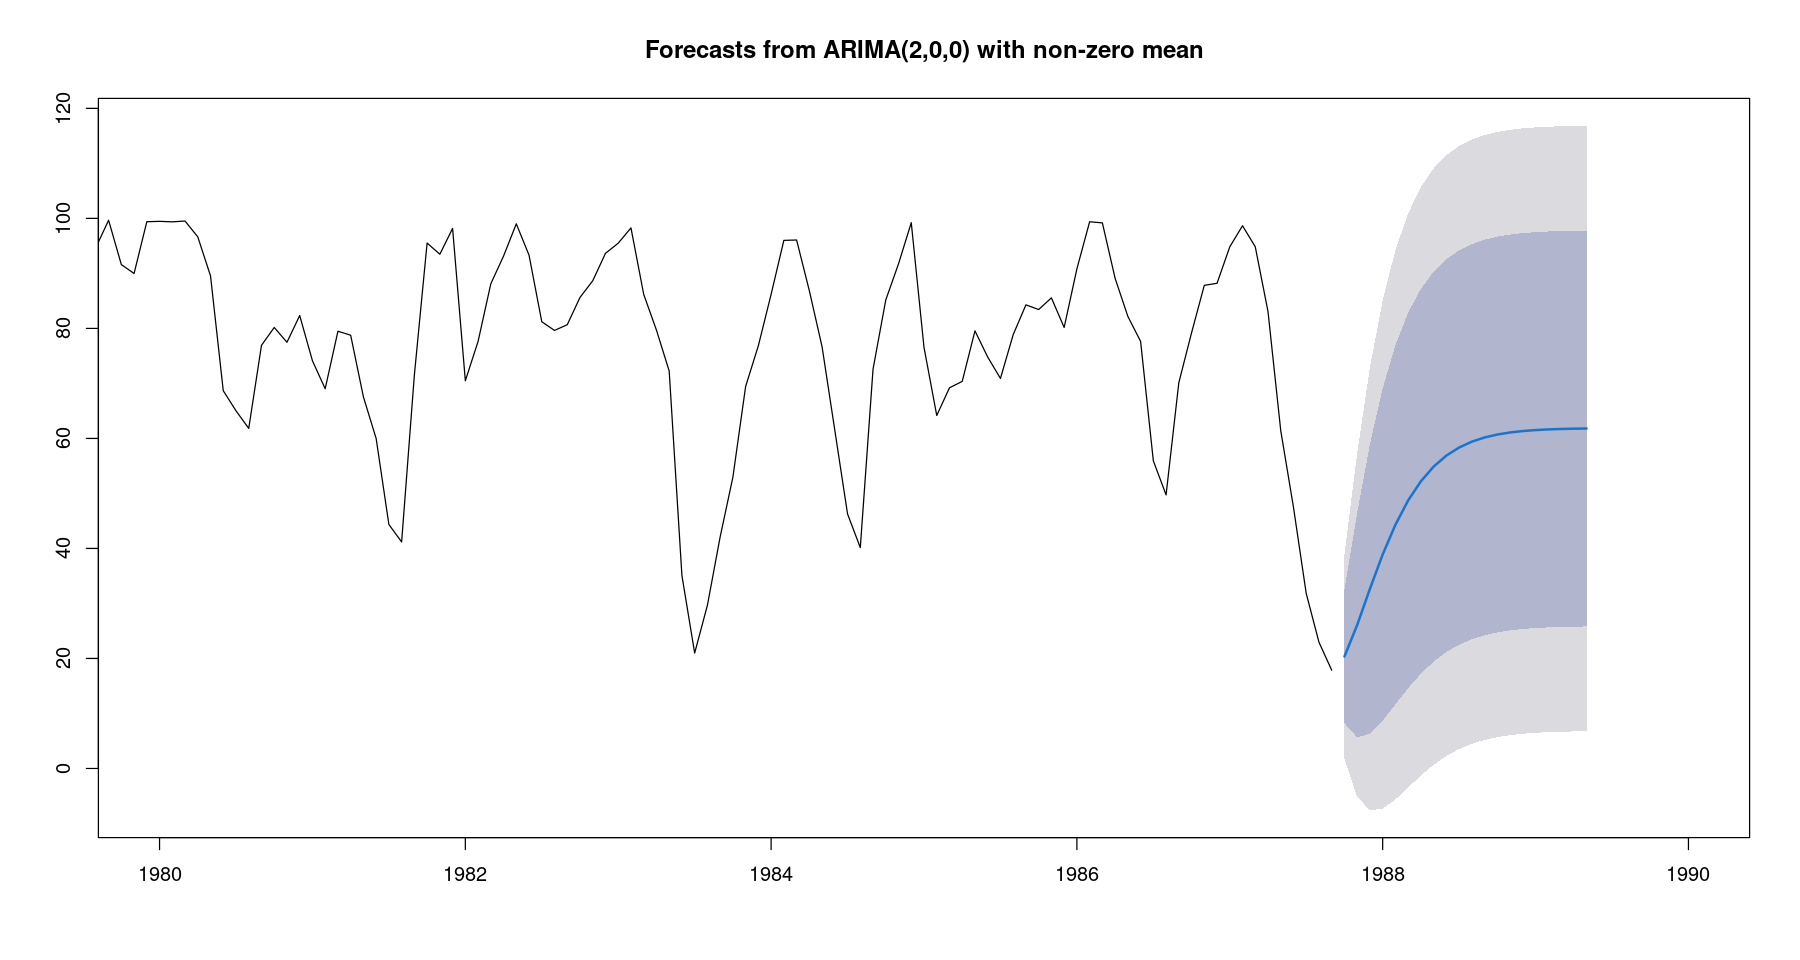

In [24]:
plot(forecast(fit, h=20),xlim=c(1980,1990))

In [5]:
forecast(fit,h=20)

         Point Forecast     Lo 80    Hi 80      Lo 95     Hi 95
Oct 1987       20.36547  8.212337 32.51860  1.7788577  38.95208
Nov 1987       26.08036  5.650820 46.50989 -5.1639223  57.32463
Dec 1987       32.65148  6.338119 58.96484 -7.5913331  72.89430
Jan 1988       38.89474  8.687752 69.10172 -7.3028592  85.09233
Feb 1988       44.30006 11.648434 76.95168 -5.6362923  94.23641
Mar 1988       48.72437 14.602547 82.84619 -3.4604540 100.90919
Apr 1988       52.20958 17.236185 87.18297 -1.2776100 105.69676
May 1988       54.87831 19.428054 90.32857  0.6618219 109.09480
Jun 1988       56.87693 21.167736 92.58613  2.2644292 111.48944
Jul 1988       58.34666 22.500771 94.19255  3.5251038 113.16821
Aug 1988       59.41079 23.494602 95.32698  4.4817198 114.33986
Sep 1988       60.17081 24.219331 96.12229  5.1877679 115.15385
Oct 1988       60.70697 24.738177 96.67576  5.6974476 115.71649
Nov 1988       61.08091 25.103804 97.05802  6.0586745 116.10315
Dec 1988       61.33890 25.357888 97.319

## Modelos ARIMA

En algunos casos, la serie de datos $x_t$ no es estacionaria, y no alcanza con "sacarle el trend" para volverla estacionaria.

**Ejemplo:** consideremos el paseo al azar:

$$x_{t} = x_{t-1} + w_t$$

con $w_t$ ruido blanco de varianza $\sigma^2_w$. Este proceso tiene media $0$ (no hay trend) pero no es estacionario.

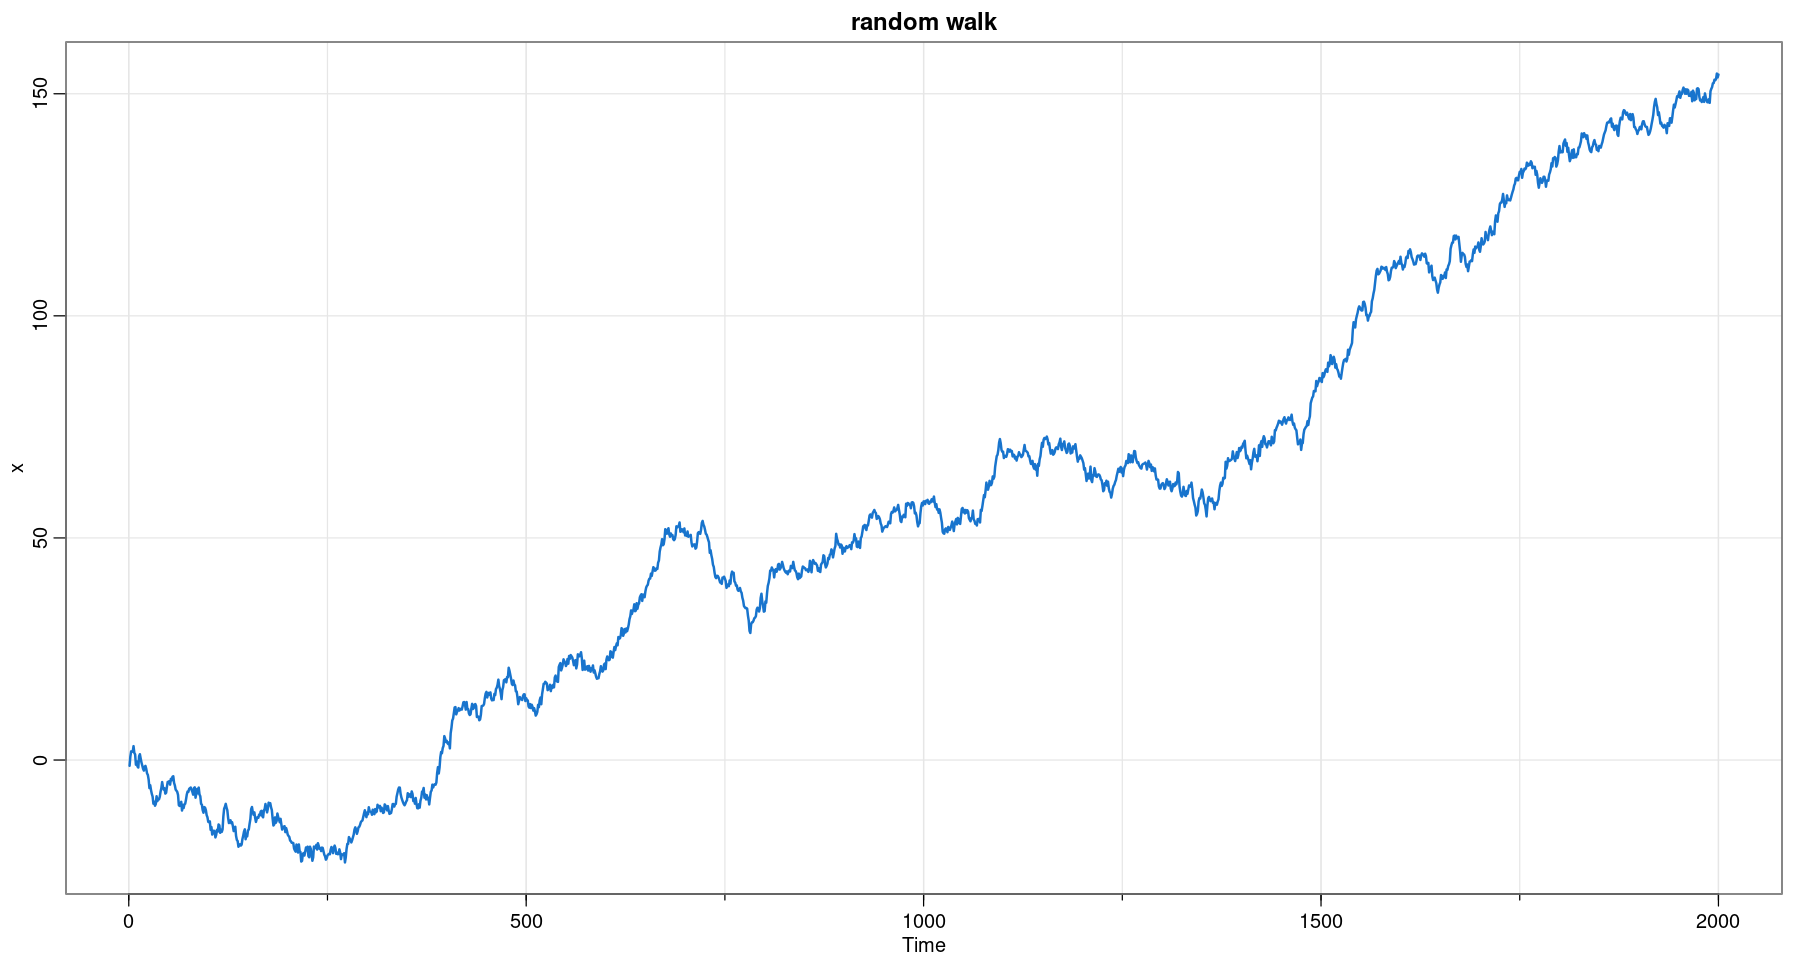

In [33]:
## Simulación de un paseo al azar con deriva

delta=.1
w = rnorm(2000); 
x = cumsum(delta+w) # acumulo los ruidos, es equivalente a la recursión con $x_0=0$.
tsplot(x, main="random walk", lwd=2, col=4)


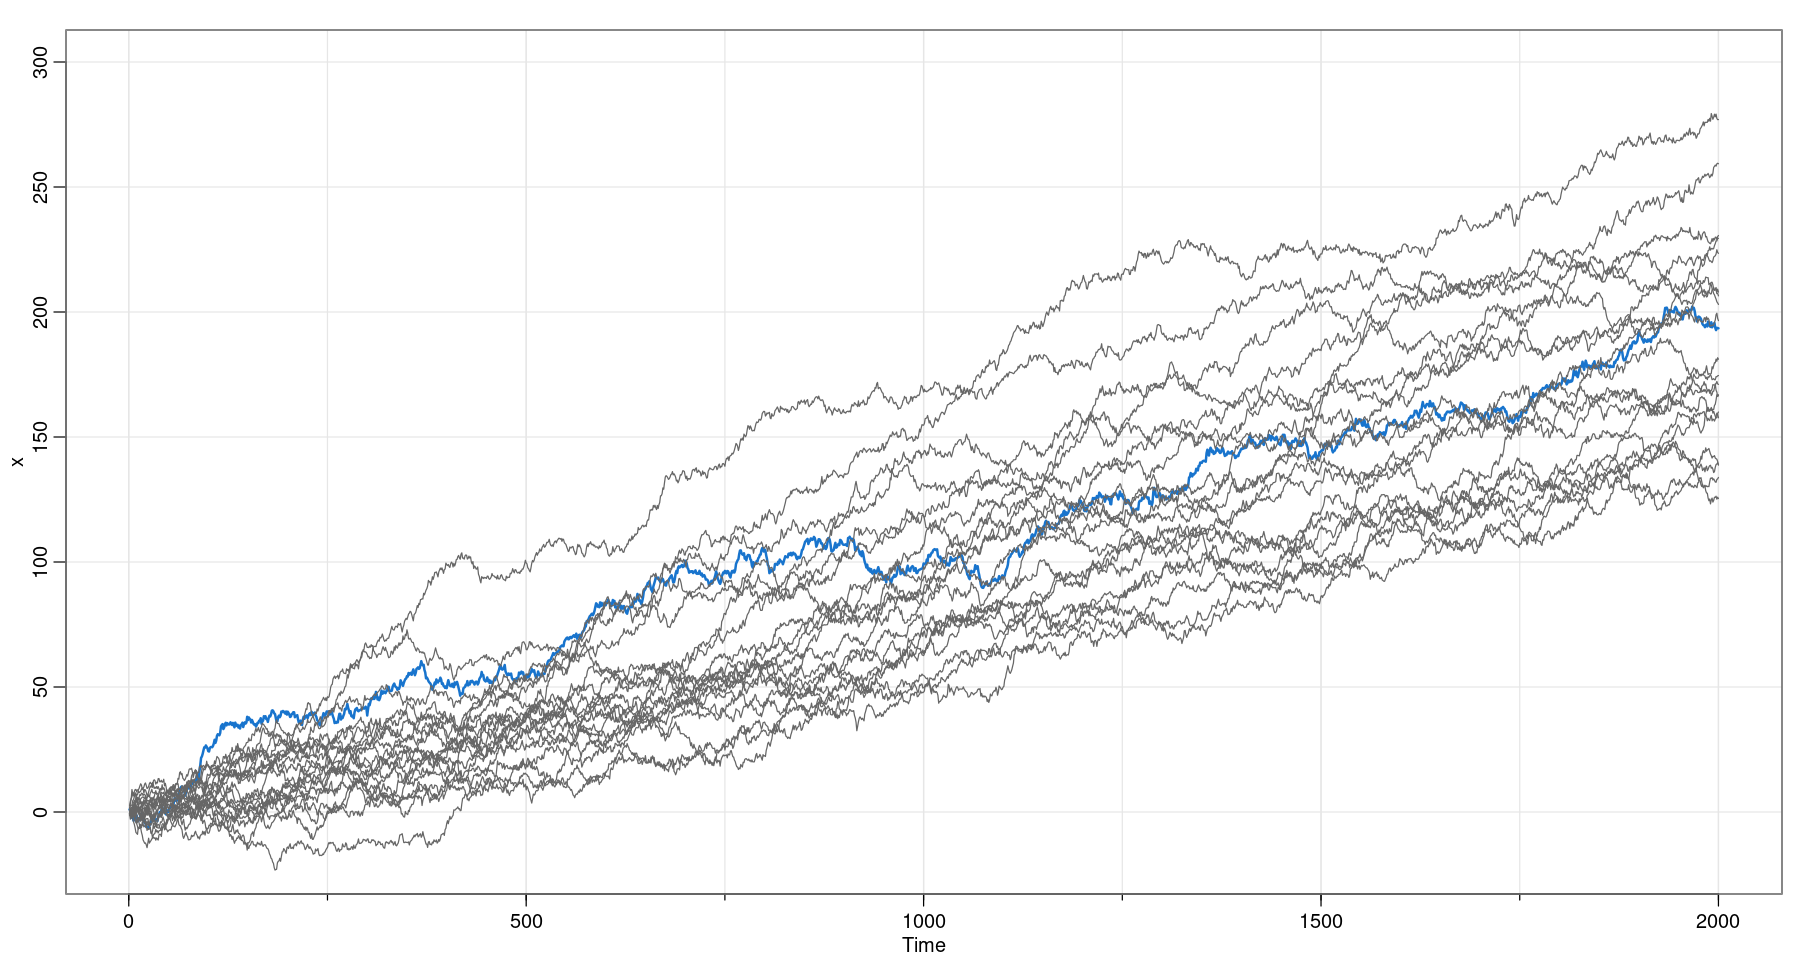

In [35]:
## Simulación de un paseo al azar

tsplot(x,ylim=c(-20,300), lwd=2, col=4)

for (i in rep(1,20)) {
    w = rnorm(2000); 
    x = cumsum(delta+w) # acumulo los ruidos, es equivalente a la recursión con $x_0=0$.
    lines(x, main="random walk", col=gray(.4))
}

**Idea:** tomar diferencias de la serie. Sea:

$$y_t = x_t - x_{t-1} = x_{t-1} + \delta + w_t - x_{t-1} = \delta +w_t$$

Es decir, al tomar diferencia la serie se vuelve ruido blanco puro en este caso (estacionario), a menos de la media.

[1] 0.1151761

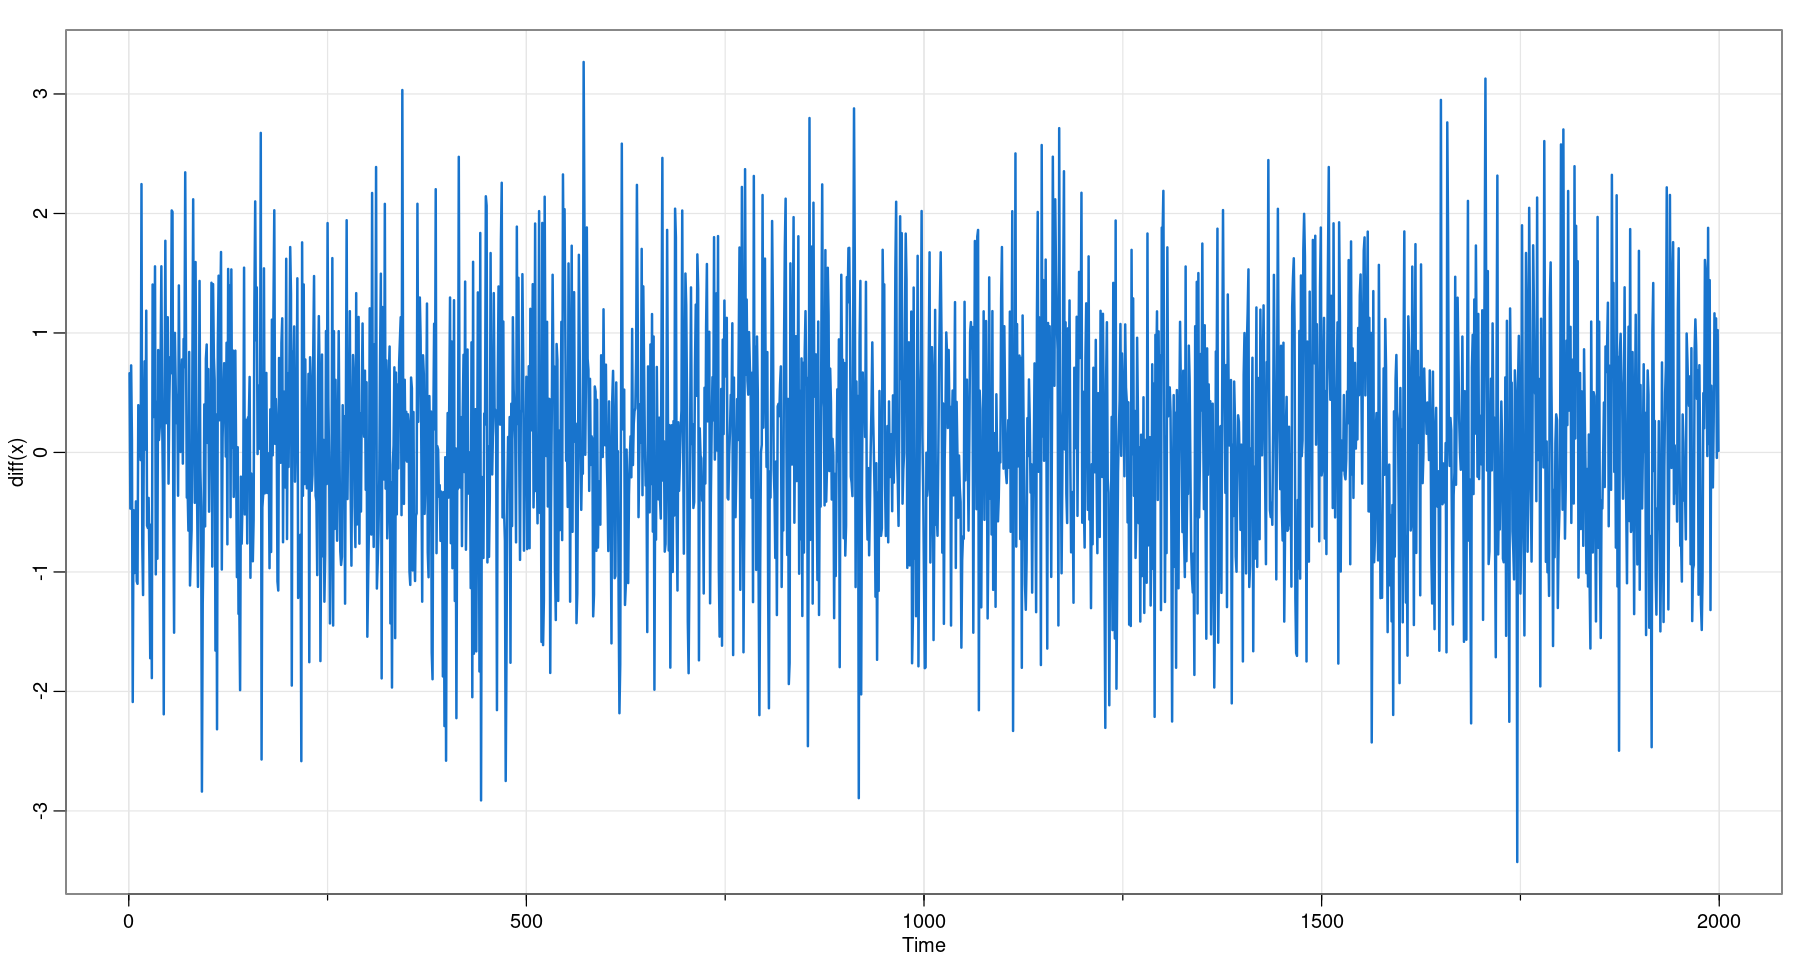

In [37]:
tsplot(diff(x), col=4, lwd=2)
mean(diff(x))

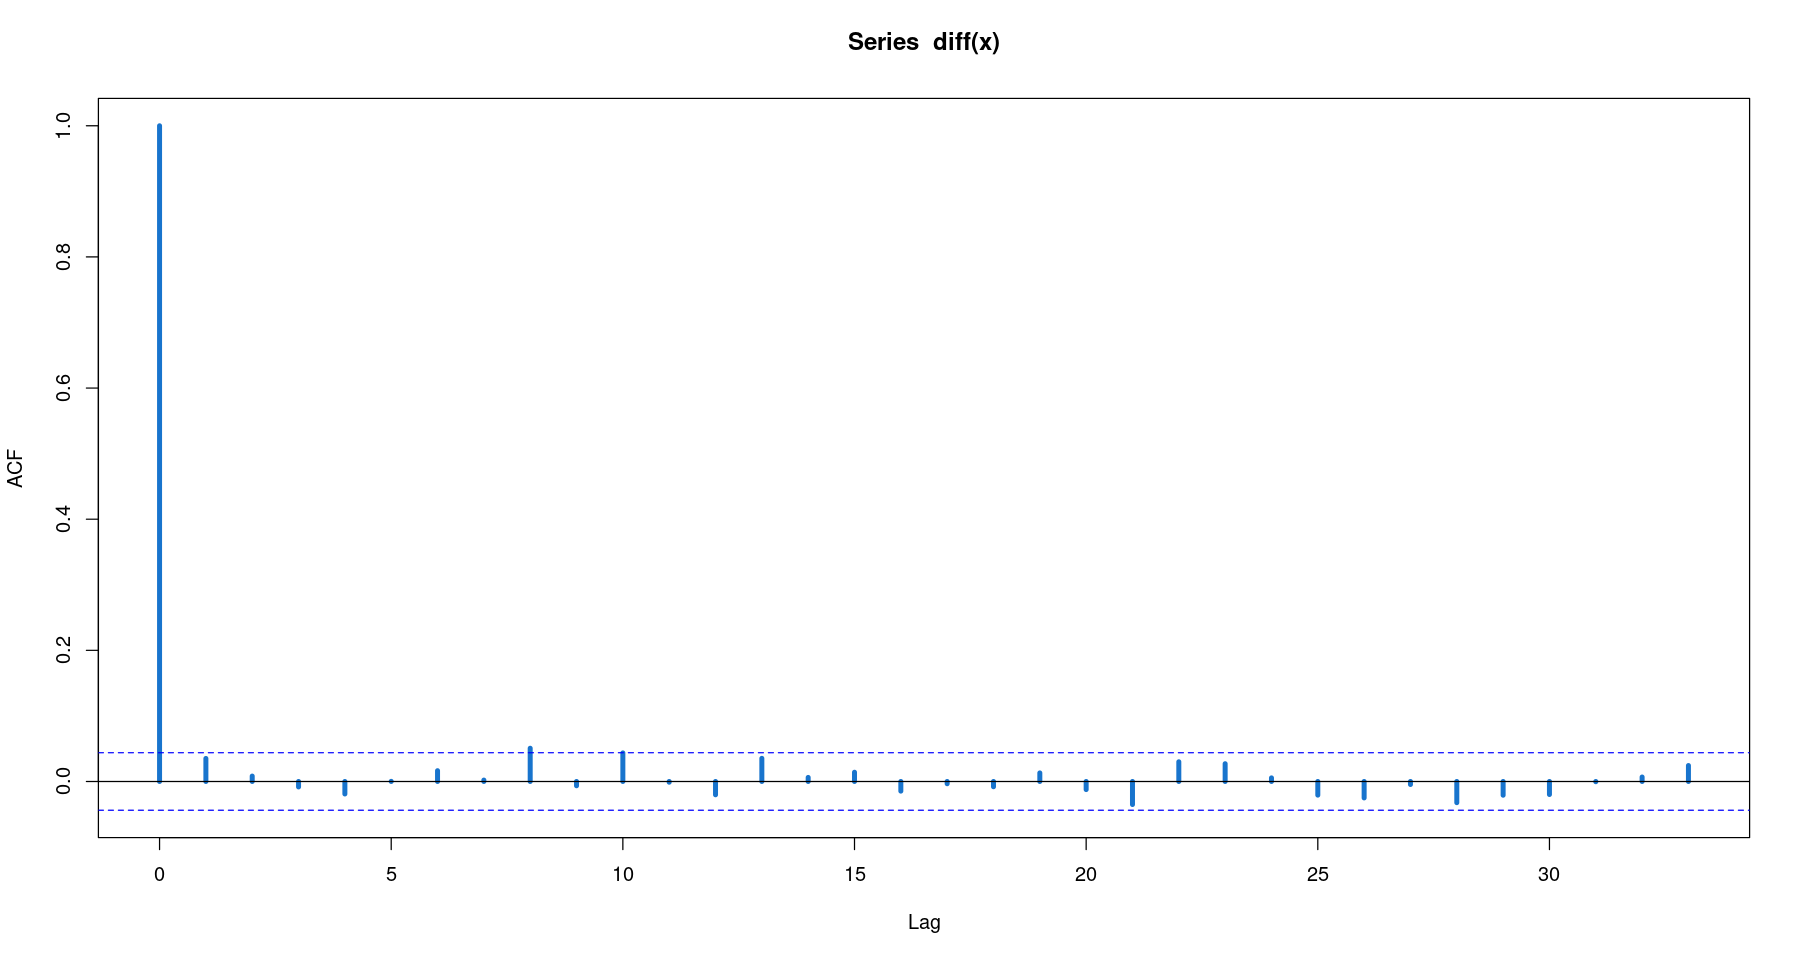

In [39]:
acf(diff(x), col=4, lwd=4)

**Ejemplo:** serie con trend lineal.

Supongamos que:
$$x_t = \mu_t + y_t$$

con $\mu_t = \beta_0 + \beta_1 t$ e $y_t$ estacionario. Entonces (introduciendo el operador $\nabla$ para las diferencias):

$$\nabla x_t = x_{t}- x_{t-1} = \mu_t + y_t - \mu_{t-1} - y_{t-1} = \beta_1 + \nabla y_t.$$

Es decir, la nueva serie "diferenciada" tiene una media $\beta_1$ que sale del trend y una componente estacionaria que es la diferencias de la serie $y$ anterior.

**Nota:** en general, si el "trend" es un polinomio de grado $n$, diferenciar $n$ veces elimina el trend.

### Modelo ARIMA

Esto lleva a la definición del modelo $ARIMA(p,d,q)$ genérico.

**Definición:** decimos que una serie $x_t$ es $ARIMA(p,d,q)$ si:
$$y_t = \nabla^d x_t$$

es un $ARMA(p,q)$. Es decir, si diferenciar la serie $d$ veces produce un proceso ARMA. El nuevo parámetro $d$ es la cantidad de veces a diferenciar.

#### Ajuste de modelos ARIMA

Para el ajuste de modelos ARIMA, simplemente podemos reutilizar todo lo visto para ARMA(p,q) una vez que sabemos cuántas veces hay que diferenciar ($d$). O sea, lo único nuevo es "descubrir" el $d$ necesario para que la serie quede estacionaria. Típicamente no se usa $d$ muy grande.

En R se puede hacer de la misma manera que lo venimos haciendo. 

**Ejemplo:**



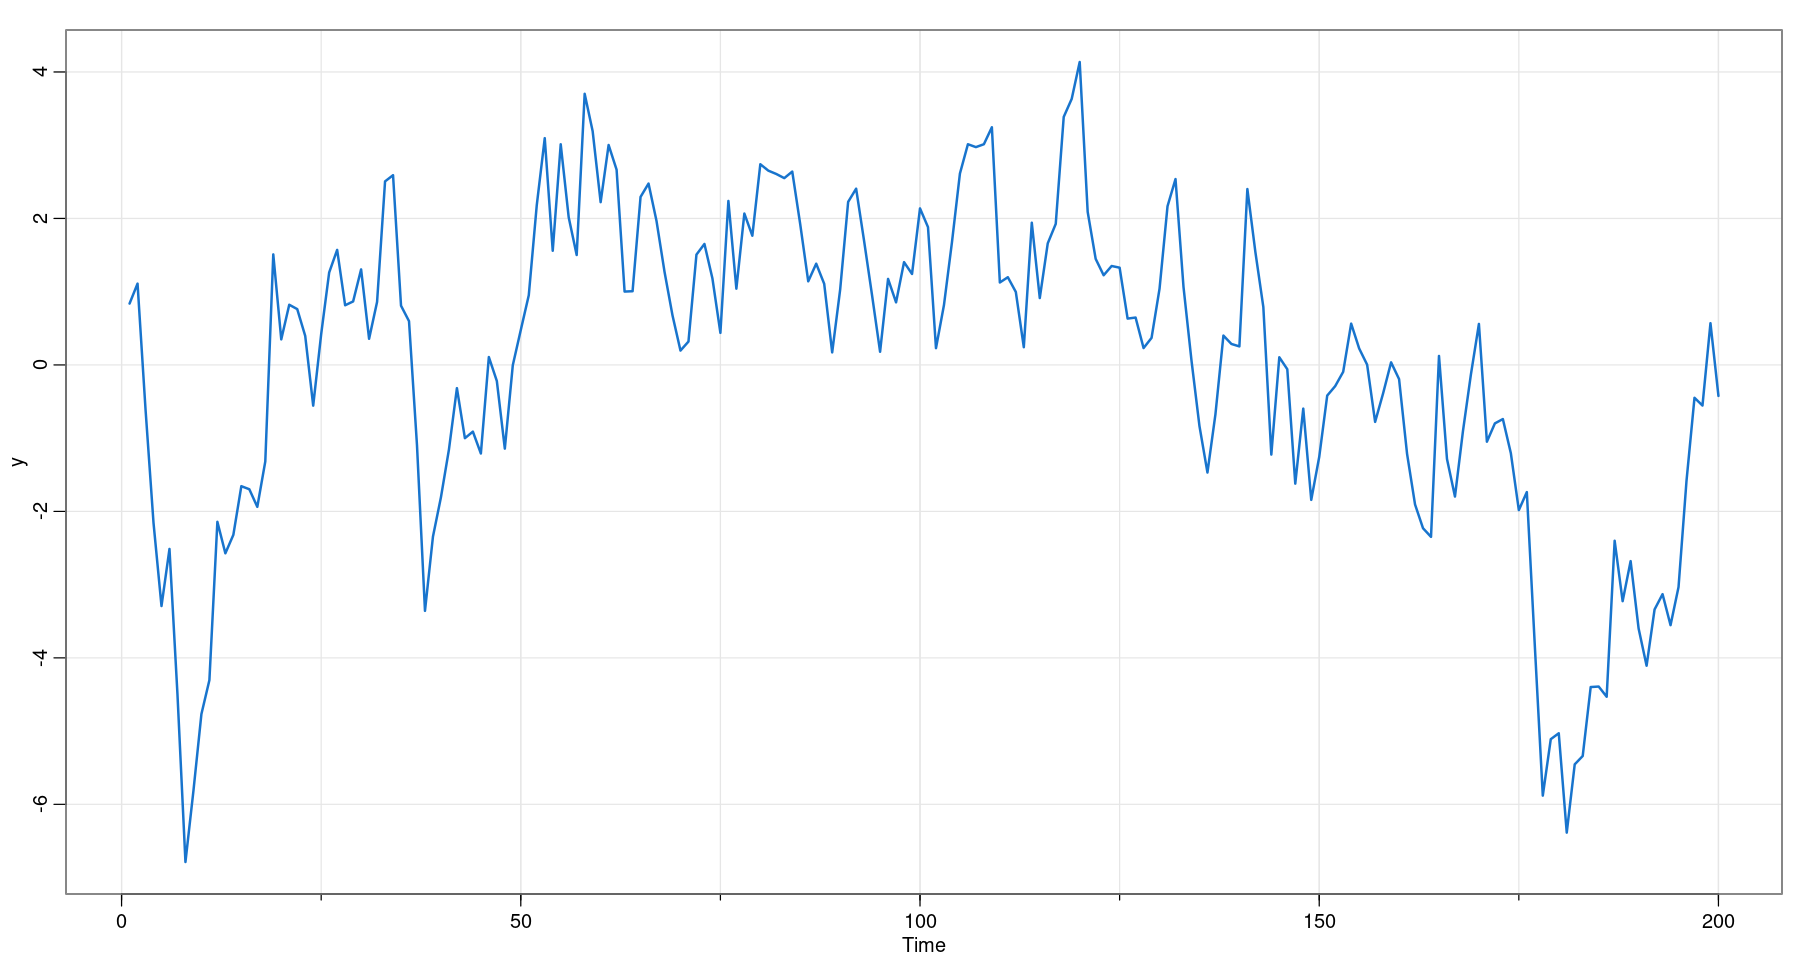

In [44]:
## construyo un ar(1) con coeficiente 0.9
y = arima.sim(n = 200, list(ar = c(0.9)))
tsplot(y, col=4, lwd=2)


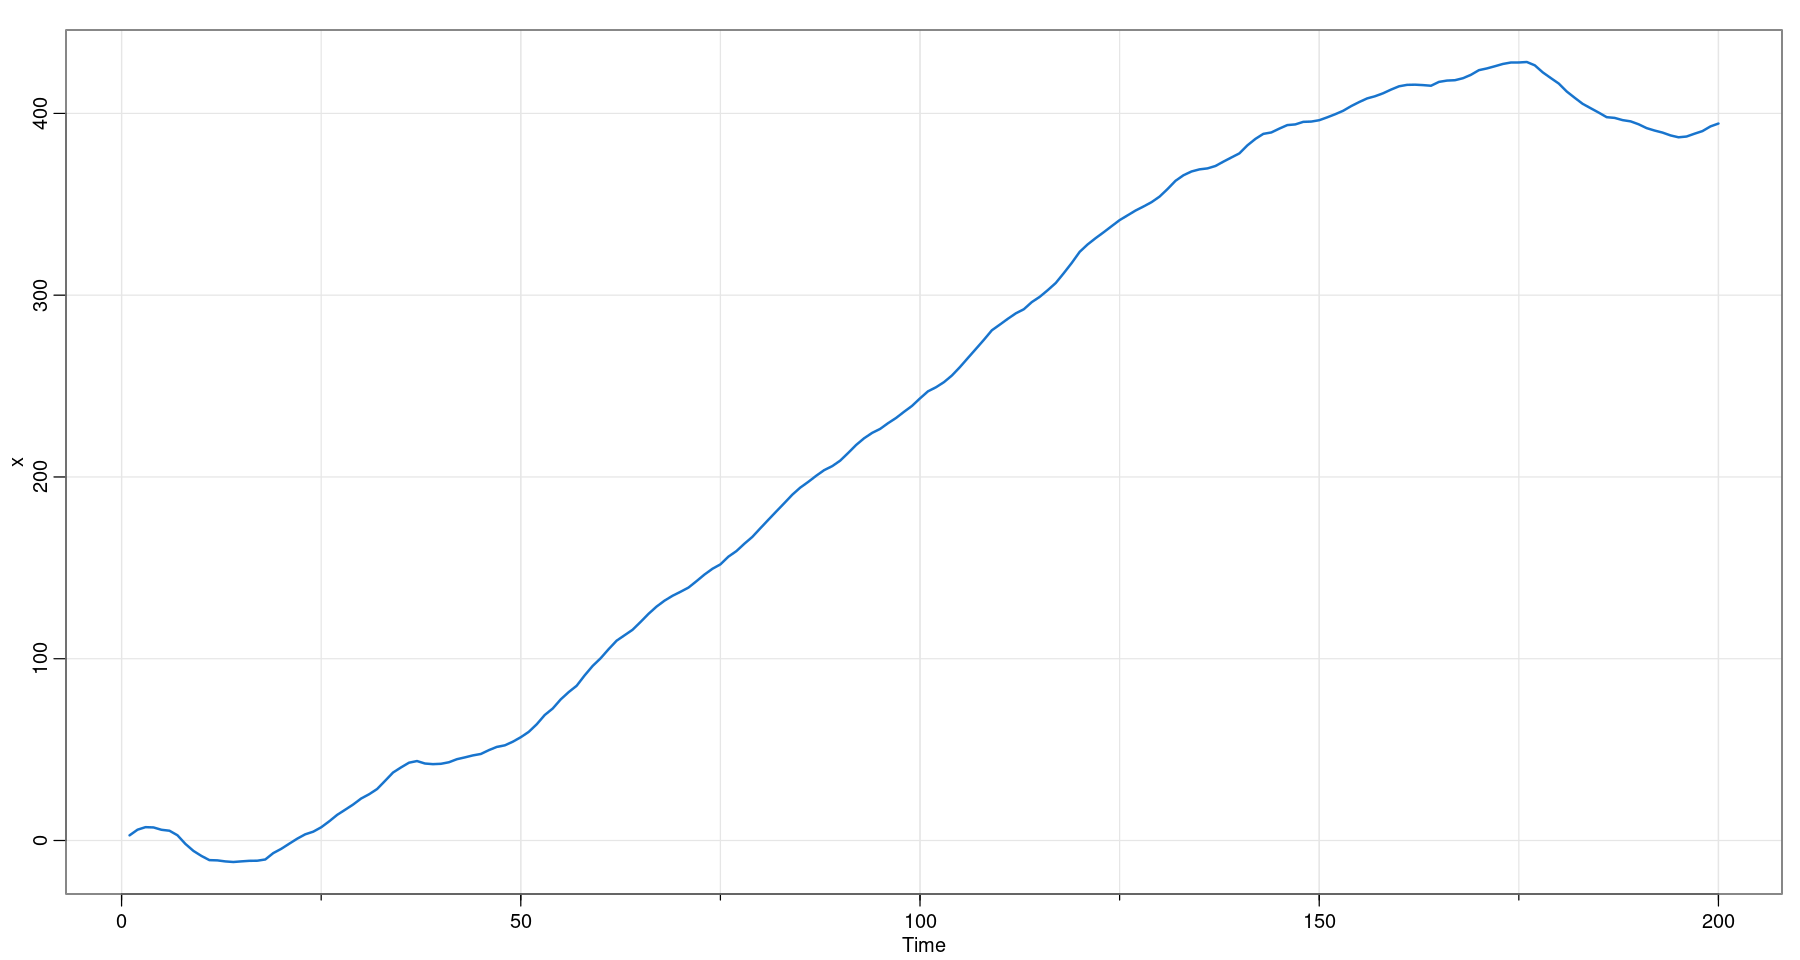

In [45]:
#Construyo la serie x con un drift delta y acumulando los y
delta=2
x=cumsum(y)+delta*(1:200)
tsplot(x, col=4, lwd=2)

[1] 1.967717

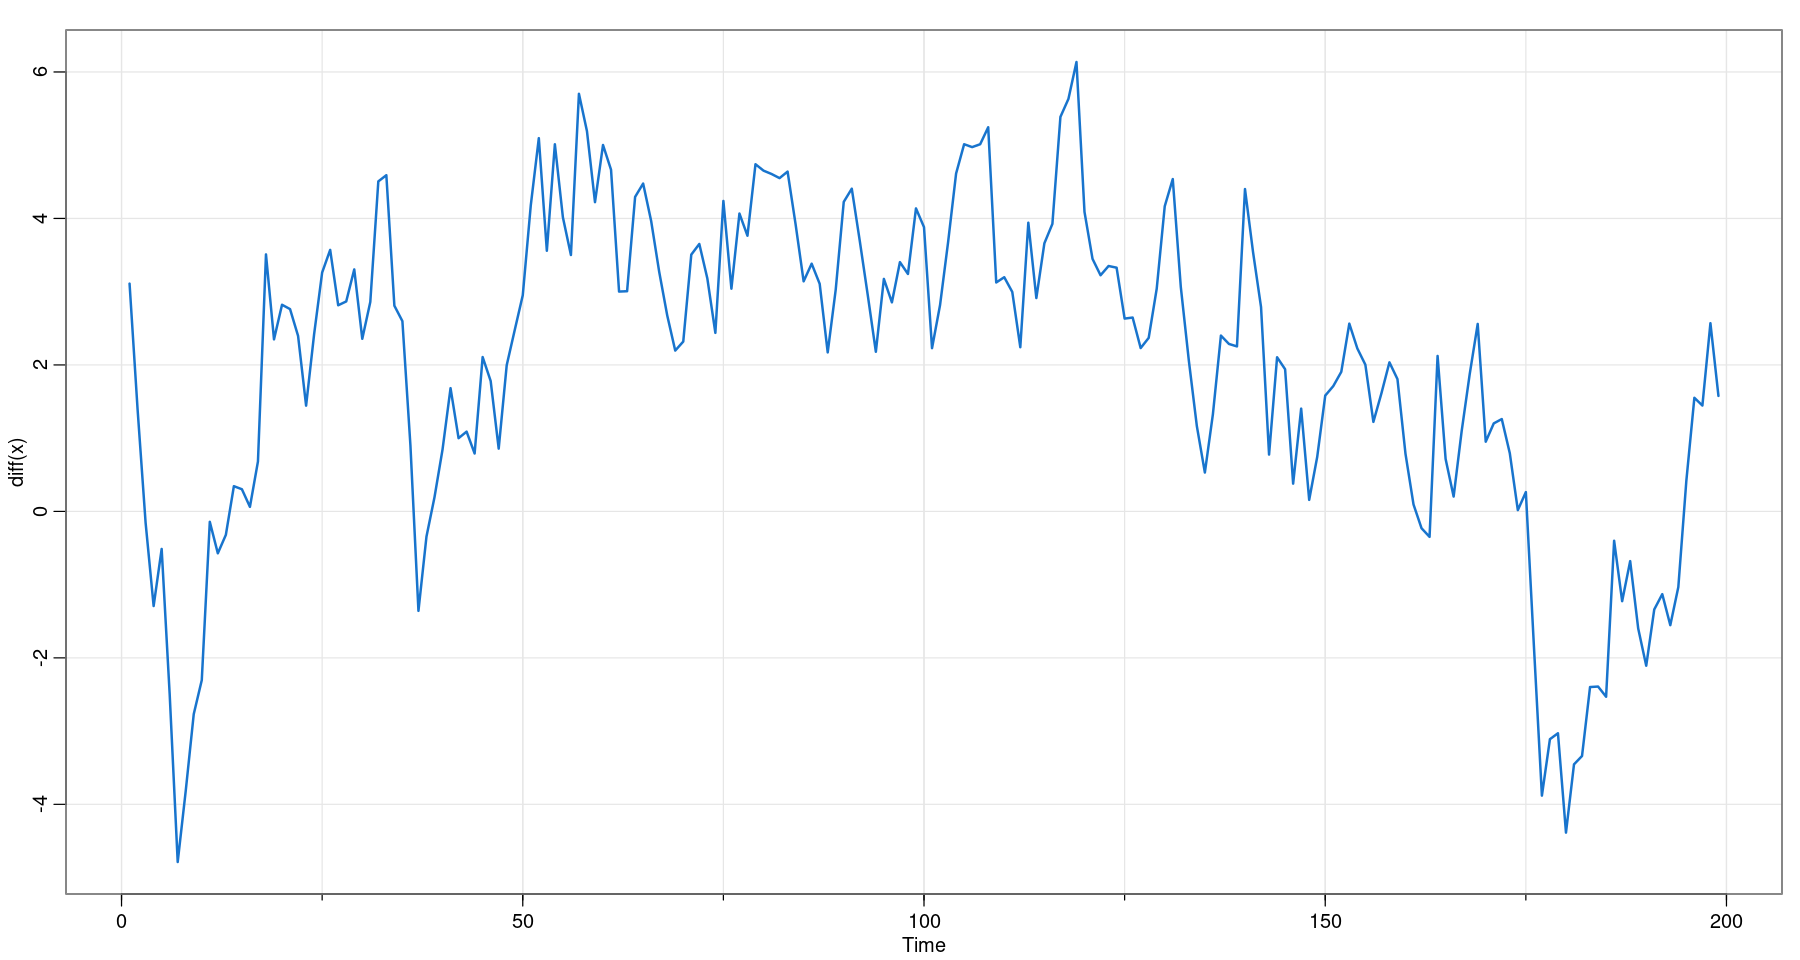

In [46]:
#Al diferenciar recupero y pero con media delta.
tsplot(diff(x), lwd=2, col=4)
mean(diff(x))

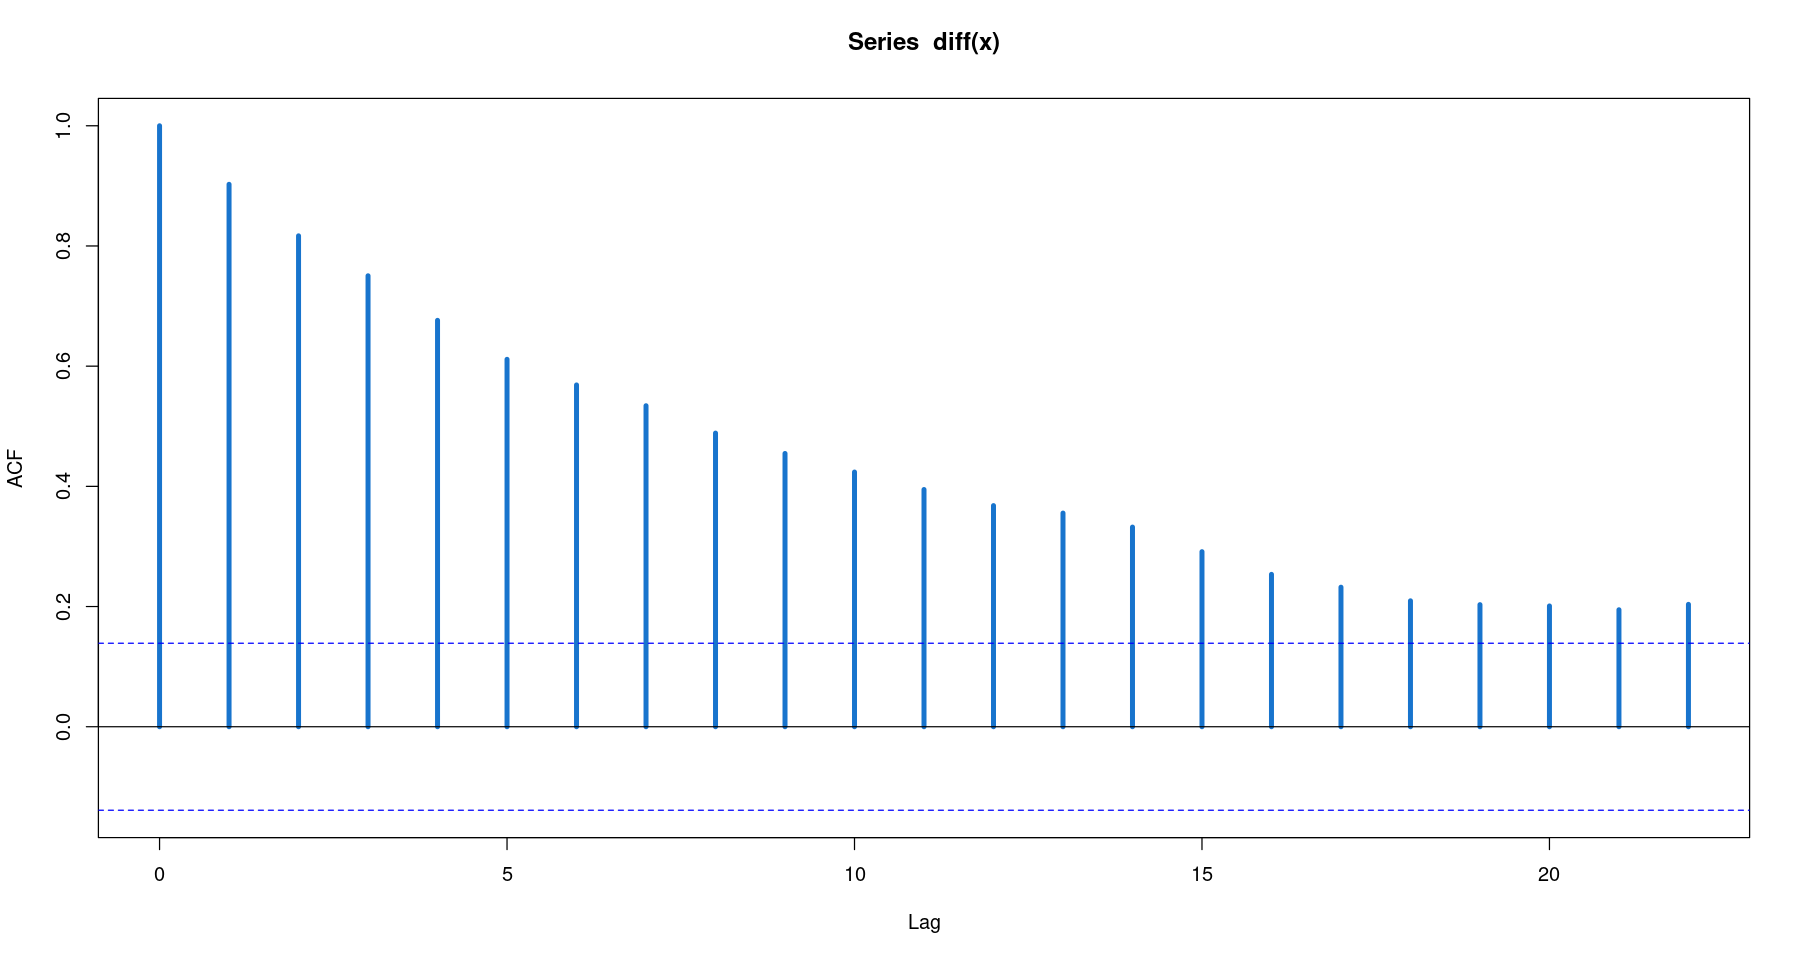

In [47]:
#las correlaciones confirman la estacionariedad (parece un AR(1) en este caso)
acf(diff(x), col=4, lwd=4)

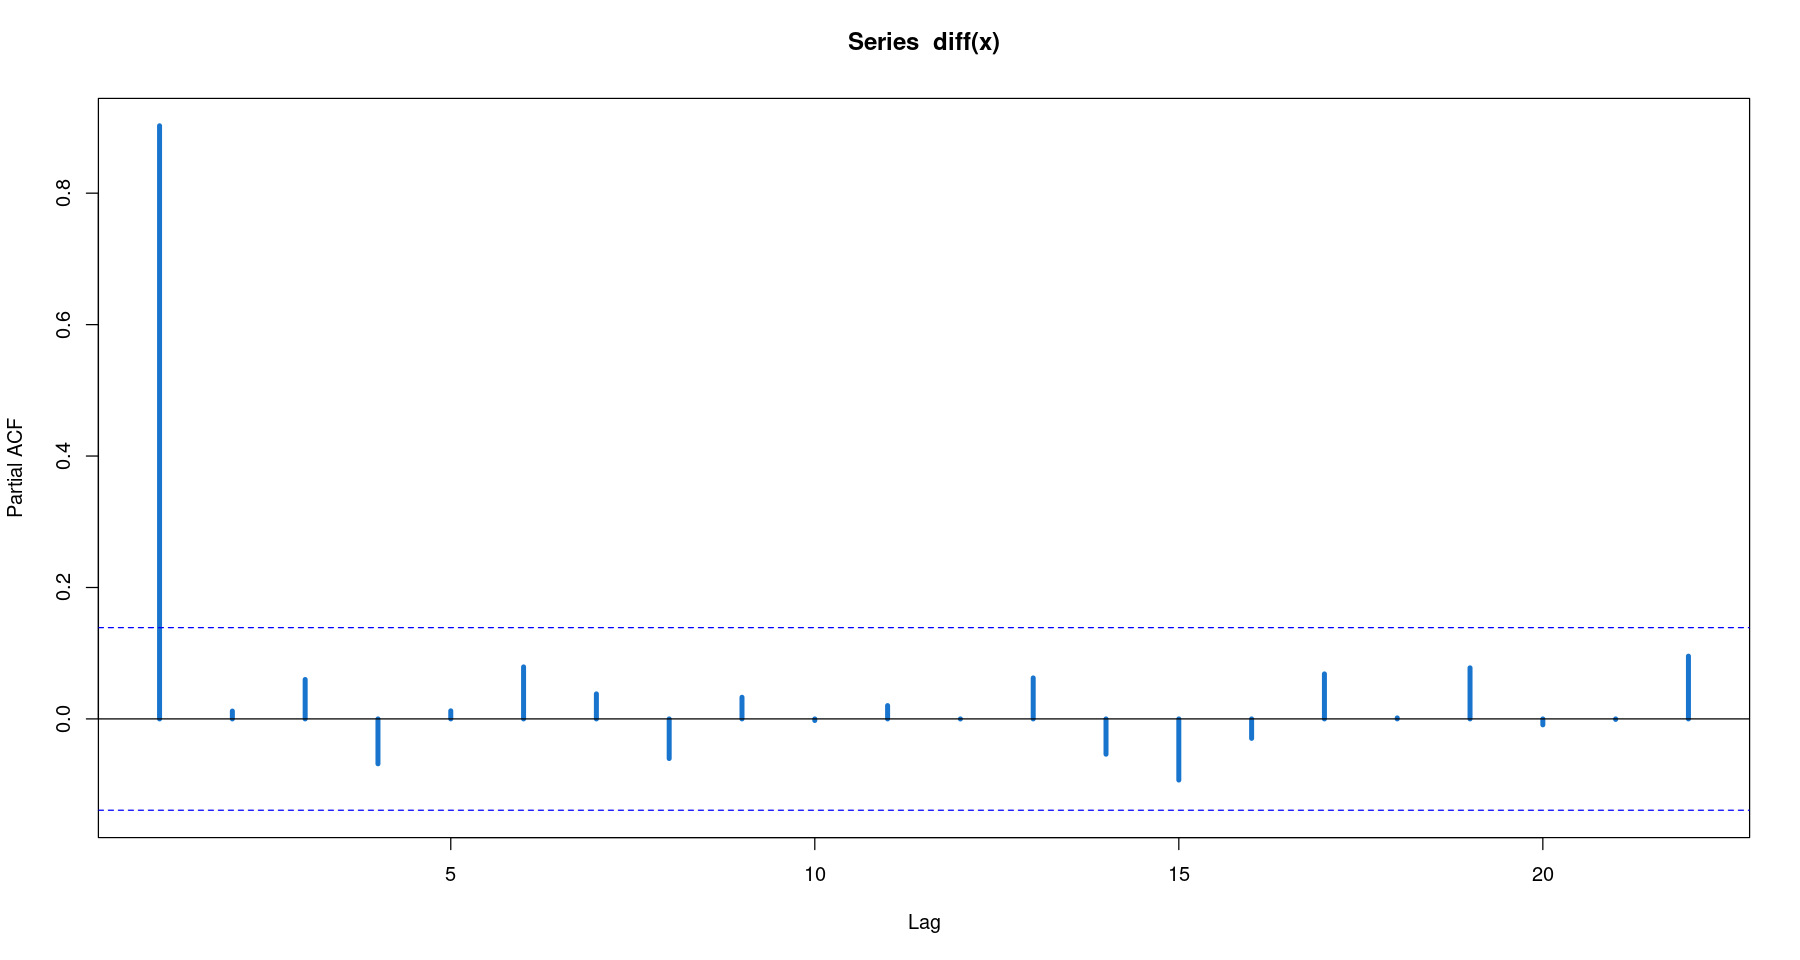

In [48]:
pacf(diff(x), col=4, lwd=4)

In [49]:
##Ajusto directo un ARIMA a la serie x usando la biblioteca forecast
## el parámetro include.drift=TRUE permite que la serie d veces diferenciada conserve el drift 
## (la media del resultado de diferenciar)

fit = Arima(x,order=c(1,1,0), include.mean=FALSE, include.drift = TRUE)
fit

Series: x 
ARIMA(1,1,0) with drift 

Coefficients:
         ar1   drift
      0.8995  1.9987
s.e.  0.0297  0.6439

sigma^2 estimated as 0.9165:  log likelihood=-273.52
AIC=553.04   AICc=553.16   BIC=562.92

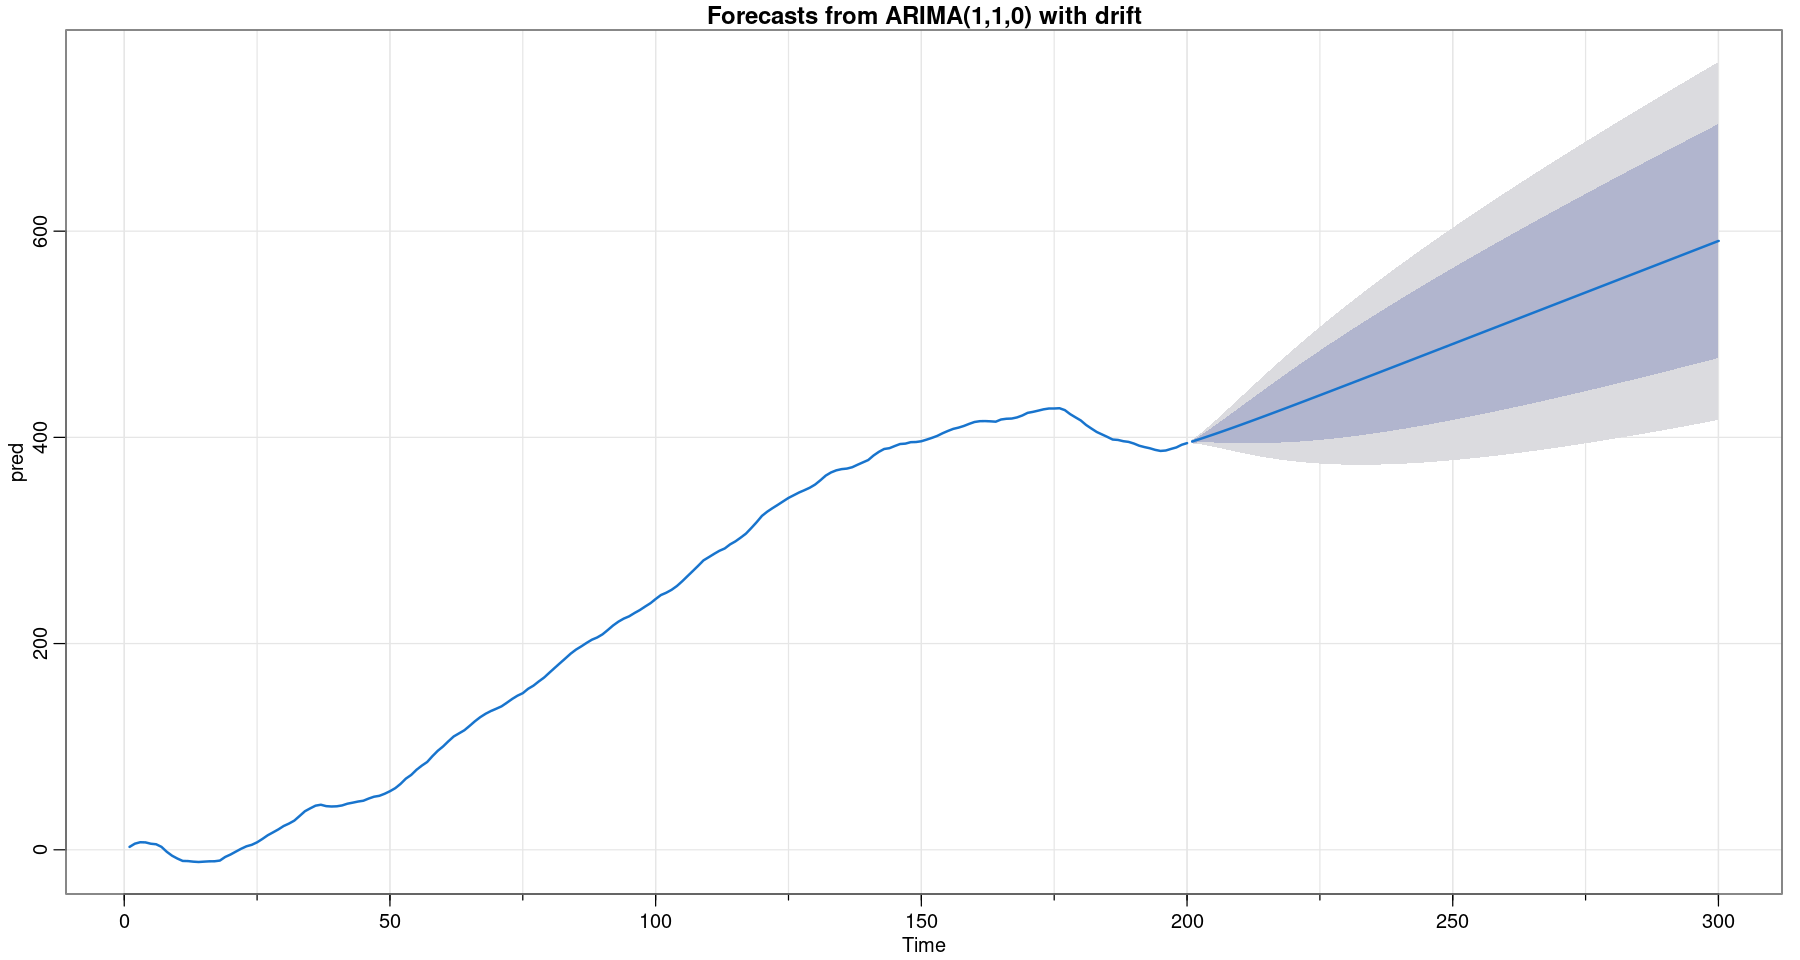

In [52]:
pred = forecast(fit,h=100)
tsplot(pred, lwd=2, col=4)

## Resumen: ARMA, ARIMA, ajuste, predicción.

Con todo lo visto, hemos construido una especie de receta (debida a Box-Jenkins) para trabajar con este tipo de modelos, a saber:
 * Graficar los datos
 * Trasnformar los datos (por ejemplo, transformación logarítmica, o detrend o ambos, diferenciación).
 * Identificar los órdenes de dependencia (acf, pacf).
 * Estimación de parámetros (fit, básicamente mínimos cuadrados o máxima verosimilitud).
 * Diagnóstico (análisis de residuos por ejemplo).
 * Elección del modelo (criterios de información tipo AIC, evitar overfitting, etc.)
 * Predicción en base a estimadores lineales calculados recursivamente e intervalos de confianza.
 

### Ejemplo: la serie GNP

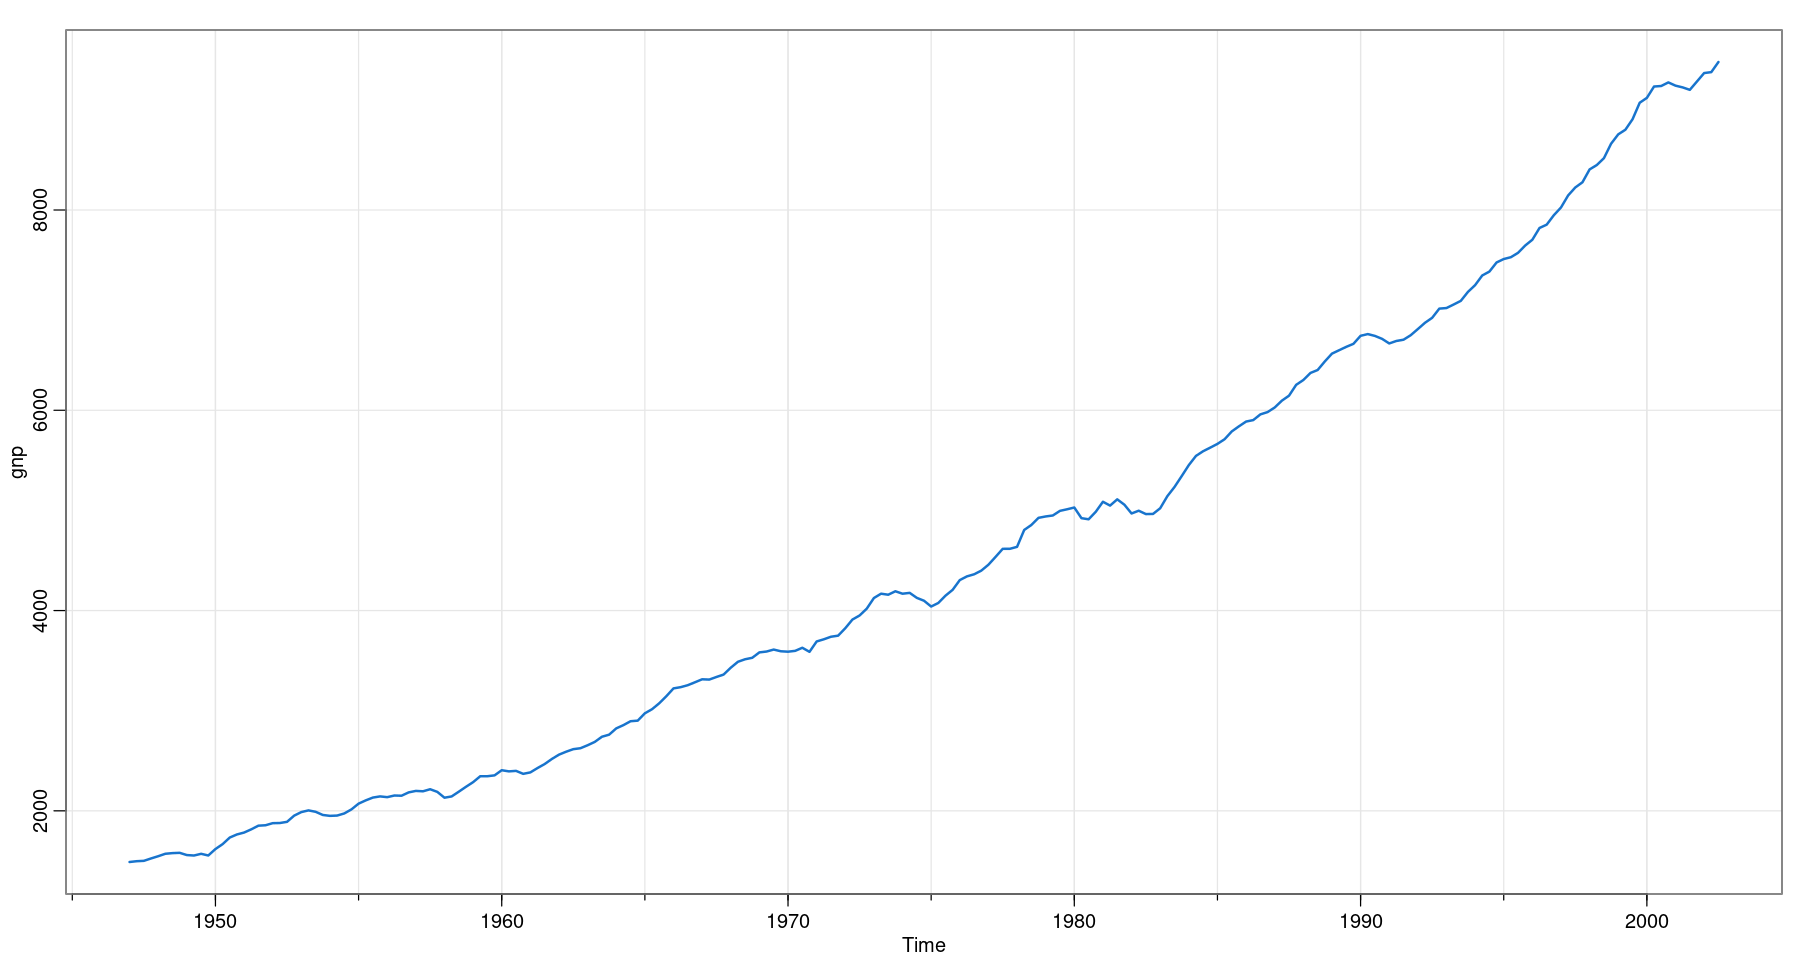

In [61]:
tsplot(gnp, lwd=2, col=4)

In [62]:
#Transformo por log
x=log(gnp)

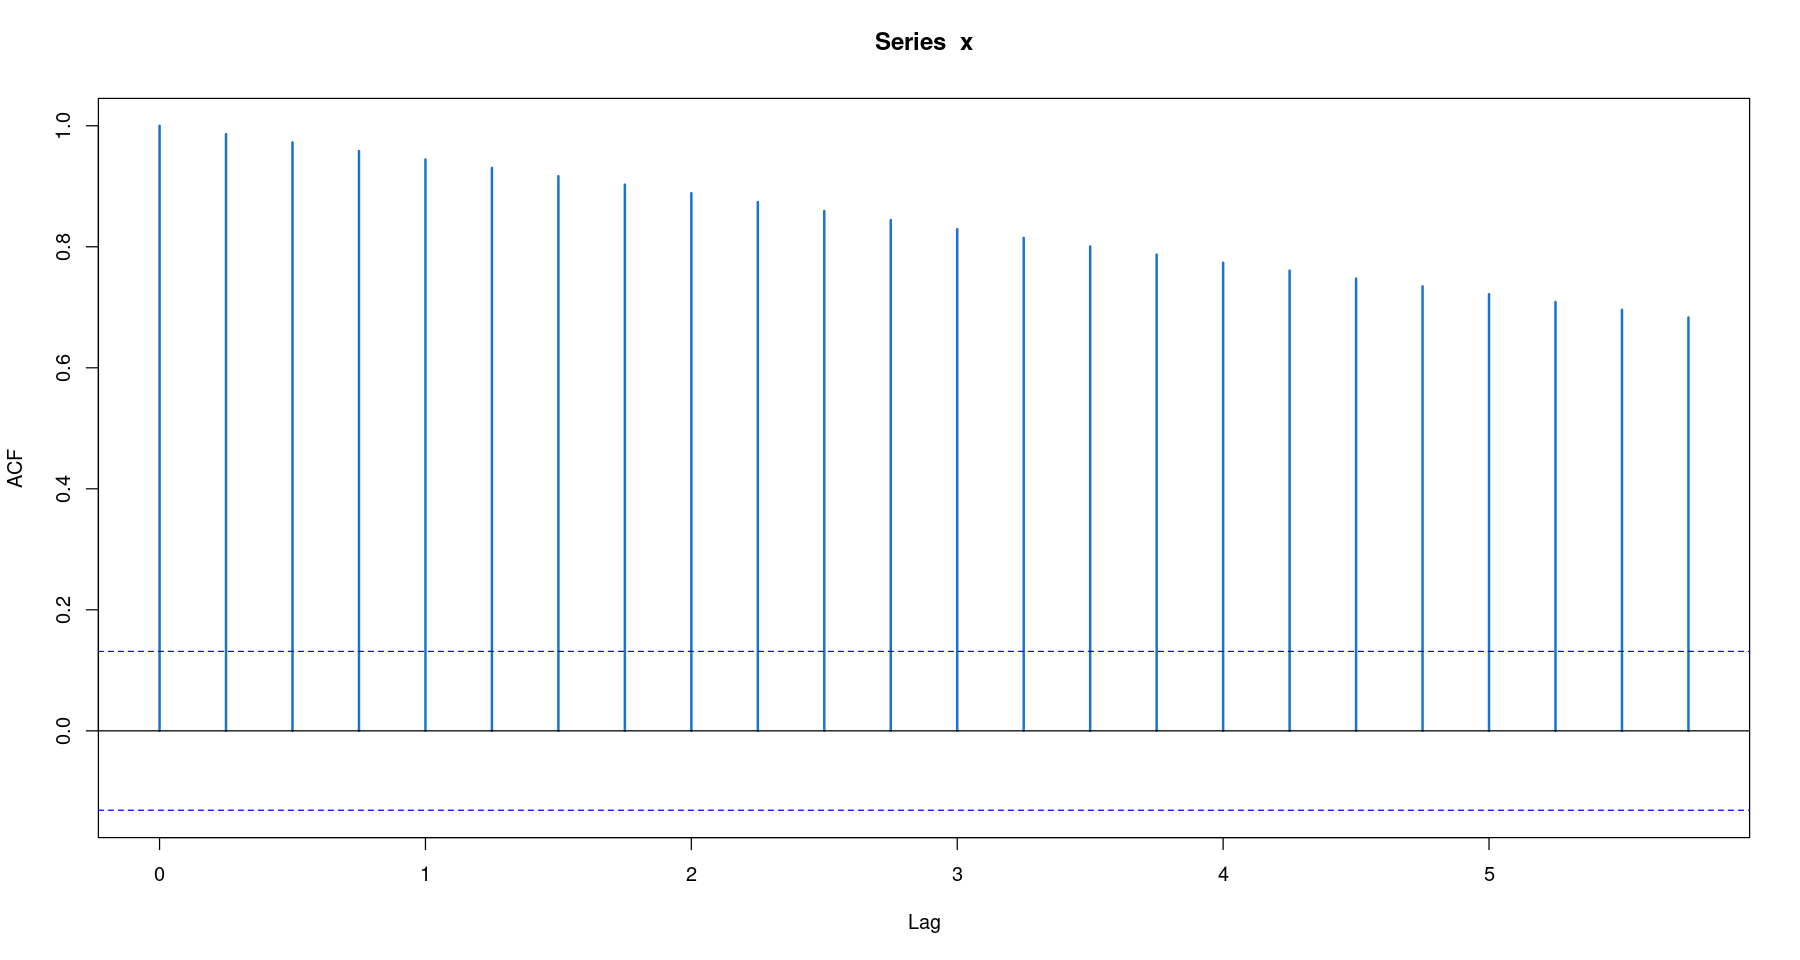

In [63]:
#Hago la ACF solo par ver que no es estacionaria
acf(x, lwd=2, col=4)

[1] 0.008337501

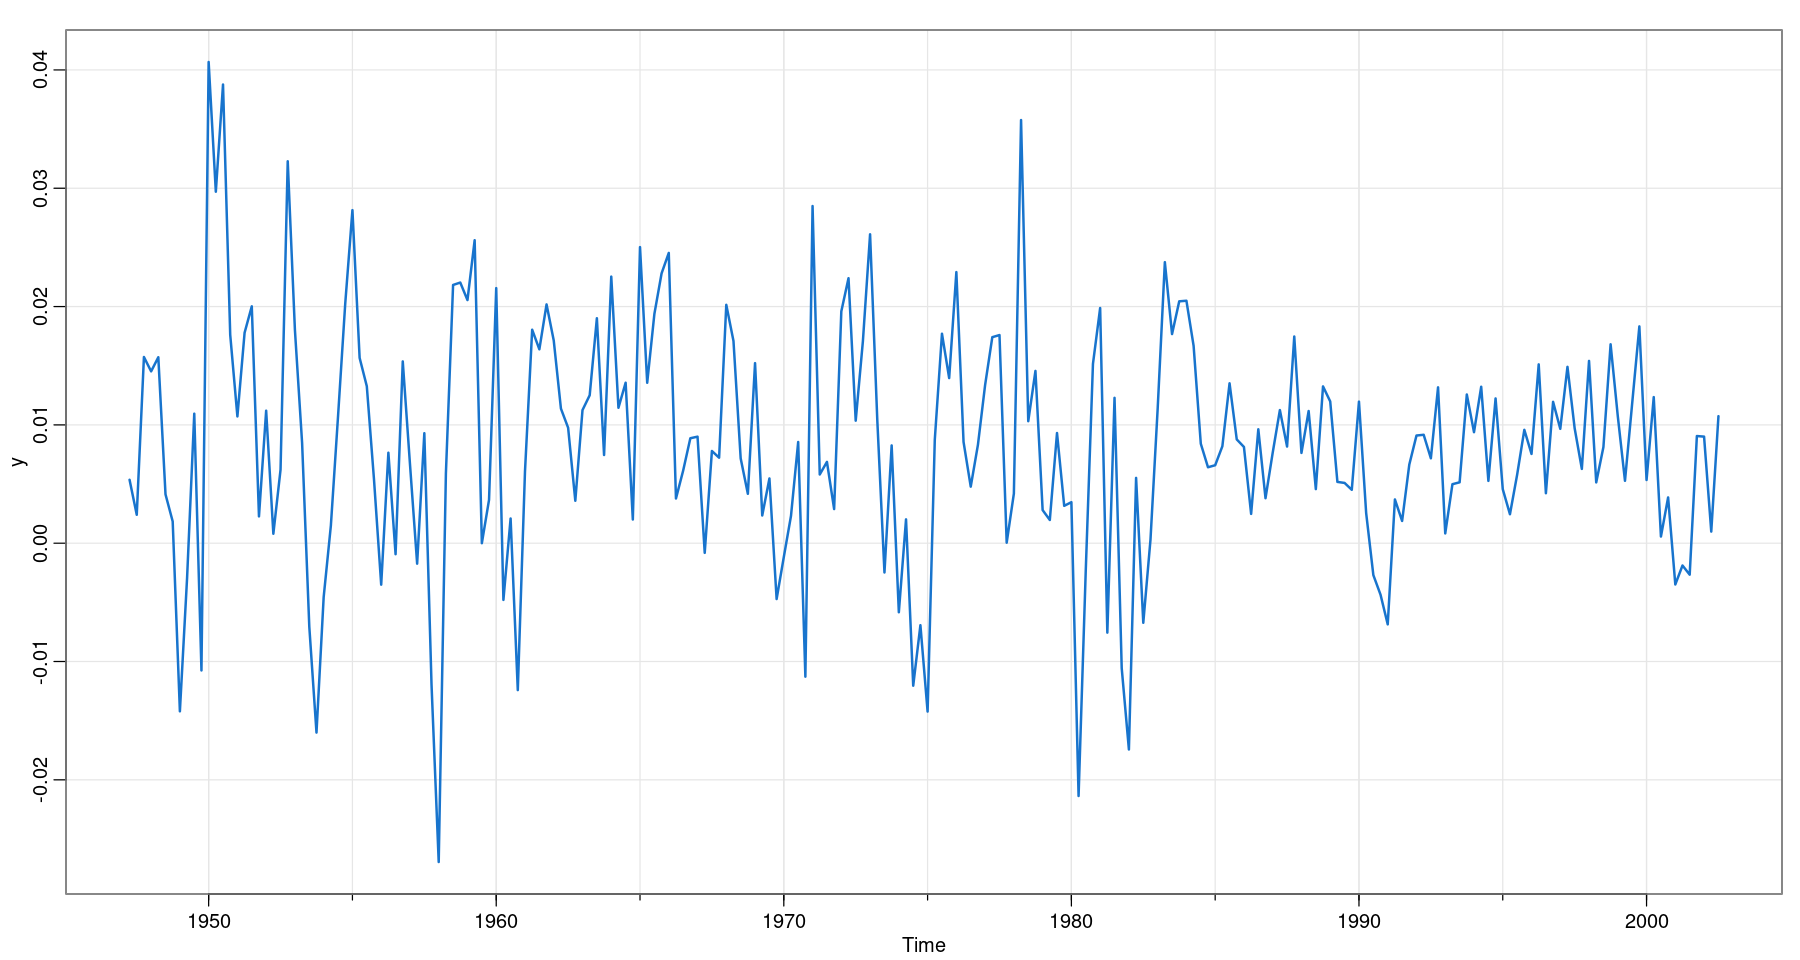

In [64]:
#diferencio y logro estacionariedad
y=diff(x)
tsplot(y, lwd=2, col=4)
mean(y)

ACF,0.35,0.19,-0.01,-0.12,-0.17,-0.11,-0.09,-0.04,0.04,0.05,⋯,0.05,0.07,0.10,0.06,0.07,-0.09,-0.05,-0.10,-0.05,0.00
PACF,0.35,0.08,-0.11,-0.12,-0.09,0.01,-0.03,-0.02,0.05,0.01,⋯,0.10,0.00,0.02,-0.04,0.01,-0.11,0.03,-0.03,0.00,0.01


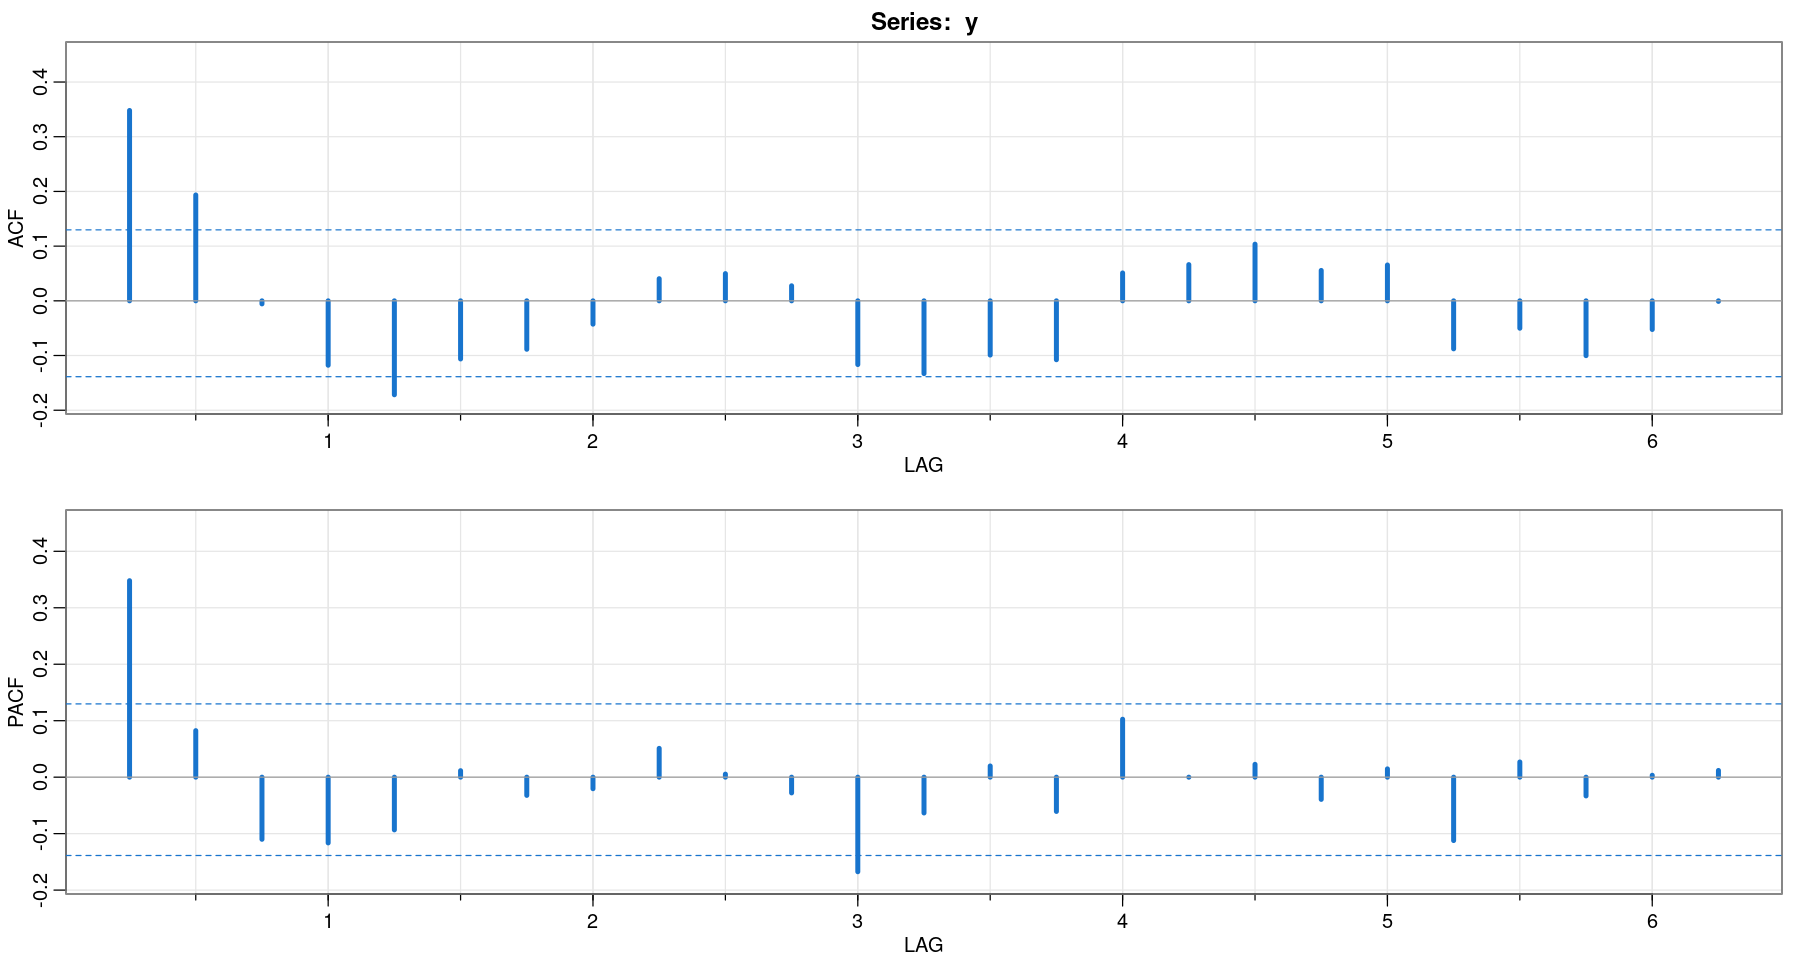

In [65]:
#Este comando hace las dos juntas (acf y pacf)
acf2(y, lwd=4, col=4)

Mirando lo anterior podemos inclinarnos por dos posibles modelos para $x$:

* ARIMA(1,1,0) ya que diferenciamos una vez y vemos que la PACF corta en 1.
* ARIMA(0,1,2) ya que diferenciamos una vez y vemos que la ACF corta en 2.
* Otras posibilidades a testear. Probemos estas y hagamos diagnóstico


In [66]:
#ARIMA(1,1,0)
fit = Arima(x,order=c(1,1,0), include.mean=FALSE, include.drift = TRUE)
fit

Series: x 
ARIMA(1,1,0) with drift 

Coefficients:
         ar1   drift
      0.3467  0.0083
s.e.  0.0627  0.0010

sigma^2 estimated as 9.136e-05:  log likelihood=718.61
AIC=-1431.22   AICc=-1431.11   BIC=-1421.01

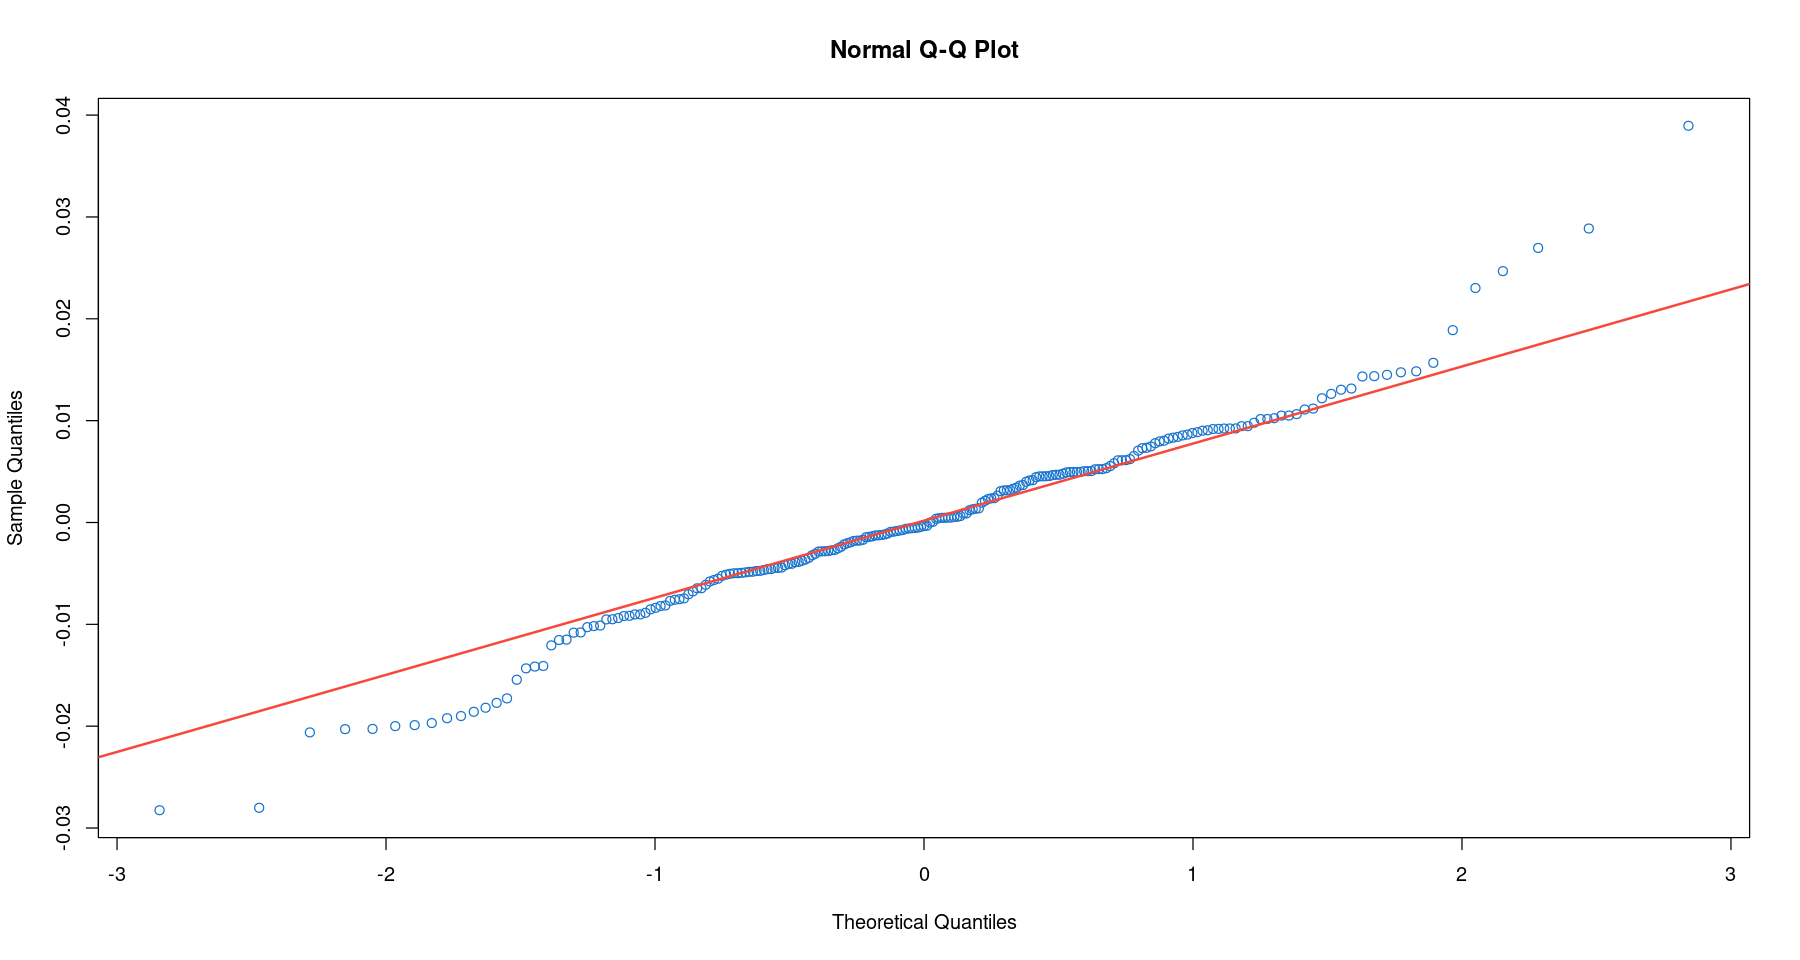

In [69]:
res = residuals(fit)
qqnorm(res, col=4)
qqline(res, col=2, lwd=2)

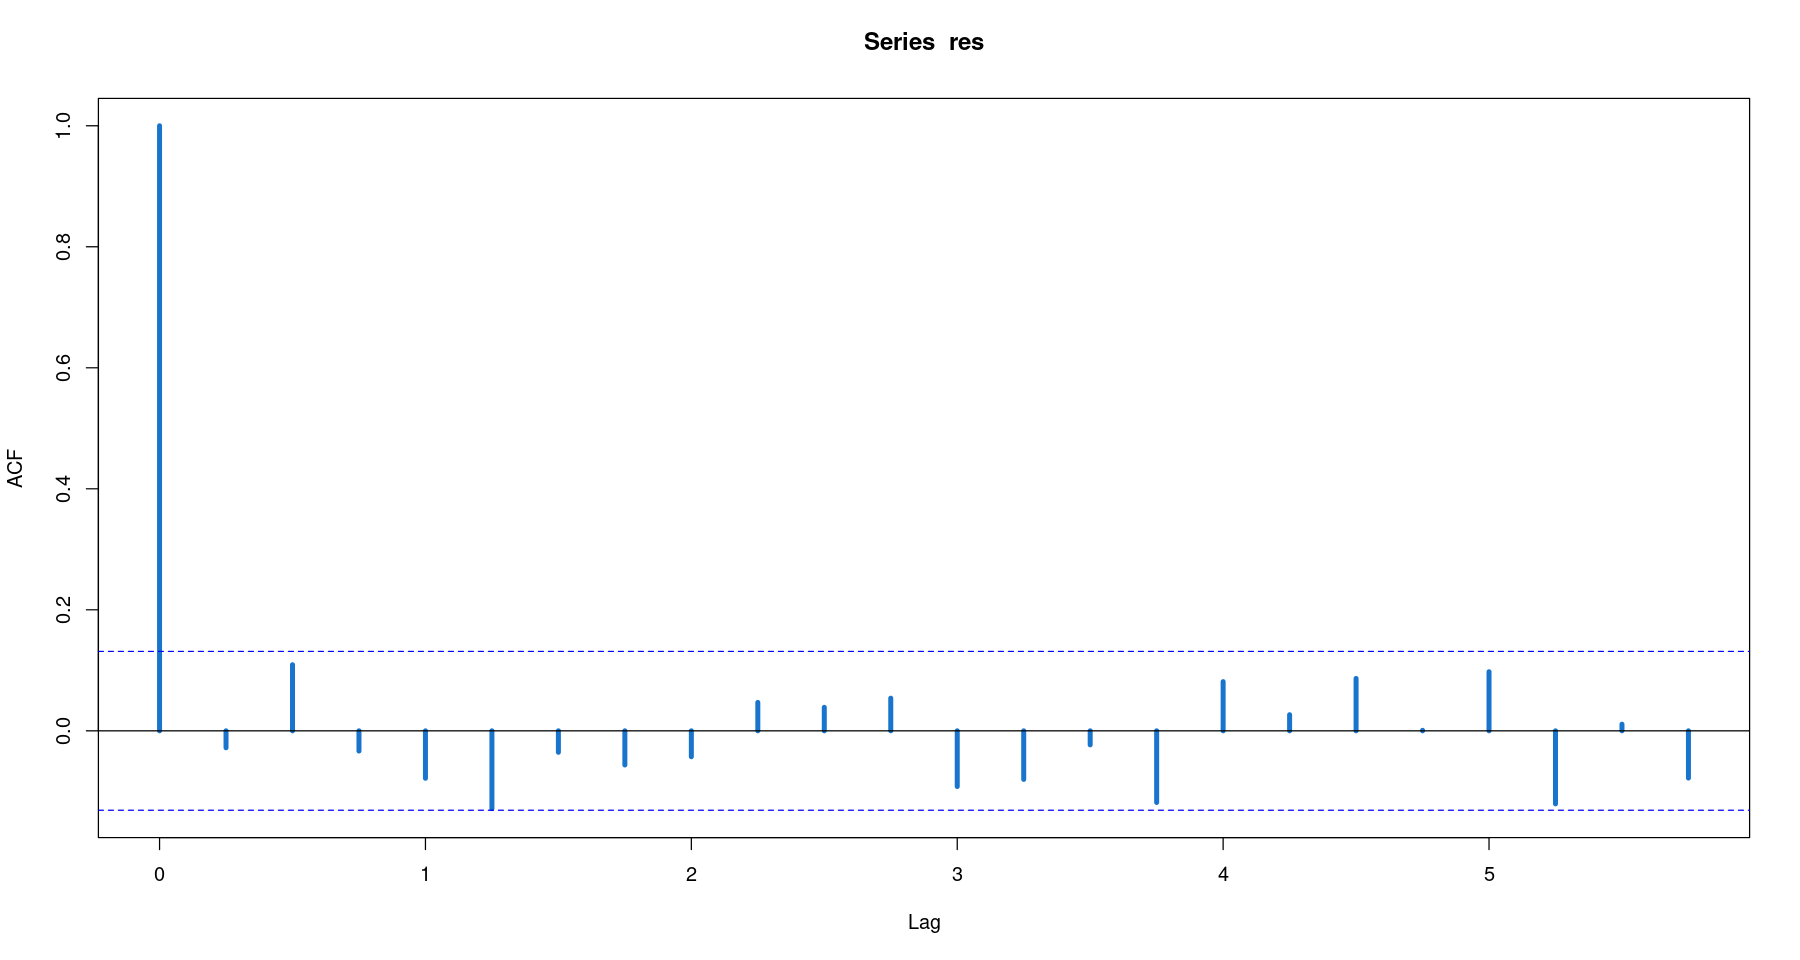

In [70]:
acf(res, col=4, lwd=4)

### Estadístico de Ljung-Box-Pierce

La serie anterior de residuos parece haber quedado "blanca". Sin embargo, es bueno disponer de un test que permita evaluar si la ACF en su conjunto es razonablemente blanca en lugar de mirar lag a lag. Para ello se usa el *estadístico de Ljung-Box-Pierce*.

$$Q = n(n+2) \sum_{h=1}^H \frac{\hat{\rho}^2_e(h)}{n-h},$$

donde $H$ es una ventana. La idea de este estadístico es acumular varias correlaciones en la ventana $H$ para ver si en su conjunto son todas despreciables (en lugar de una a una).

El estadístico $Q$ es asintóticamente $\chi^2_{H-p-q}$ por lo que si el valor de $Q$ es grande (más que el cuantil $\alpha$ de la $\chi^2$) rechazamos la hipótesis de independencia.

En general lo que se hace es mirar los $p$-valores, es decir cuánta probabilidad queda a la derecha de $Q$. Si es pequeño (ej: $p<0.05$) se rechaza la hipótesis.


	Ljung-Box test

data:  Residuals from ARIMA(1,1,0) with drift
Q* = 9.8183, df = 6, p-value = 0.1325

Model df: 2.   Total lags used: 8



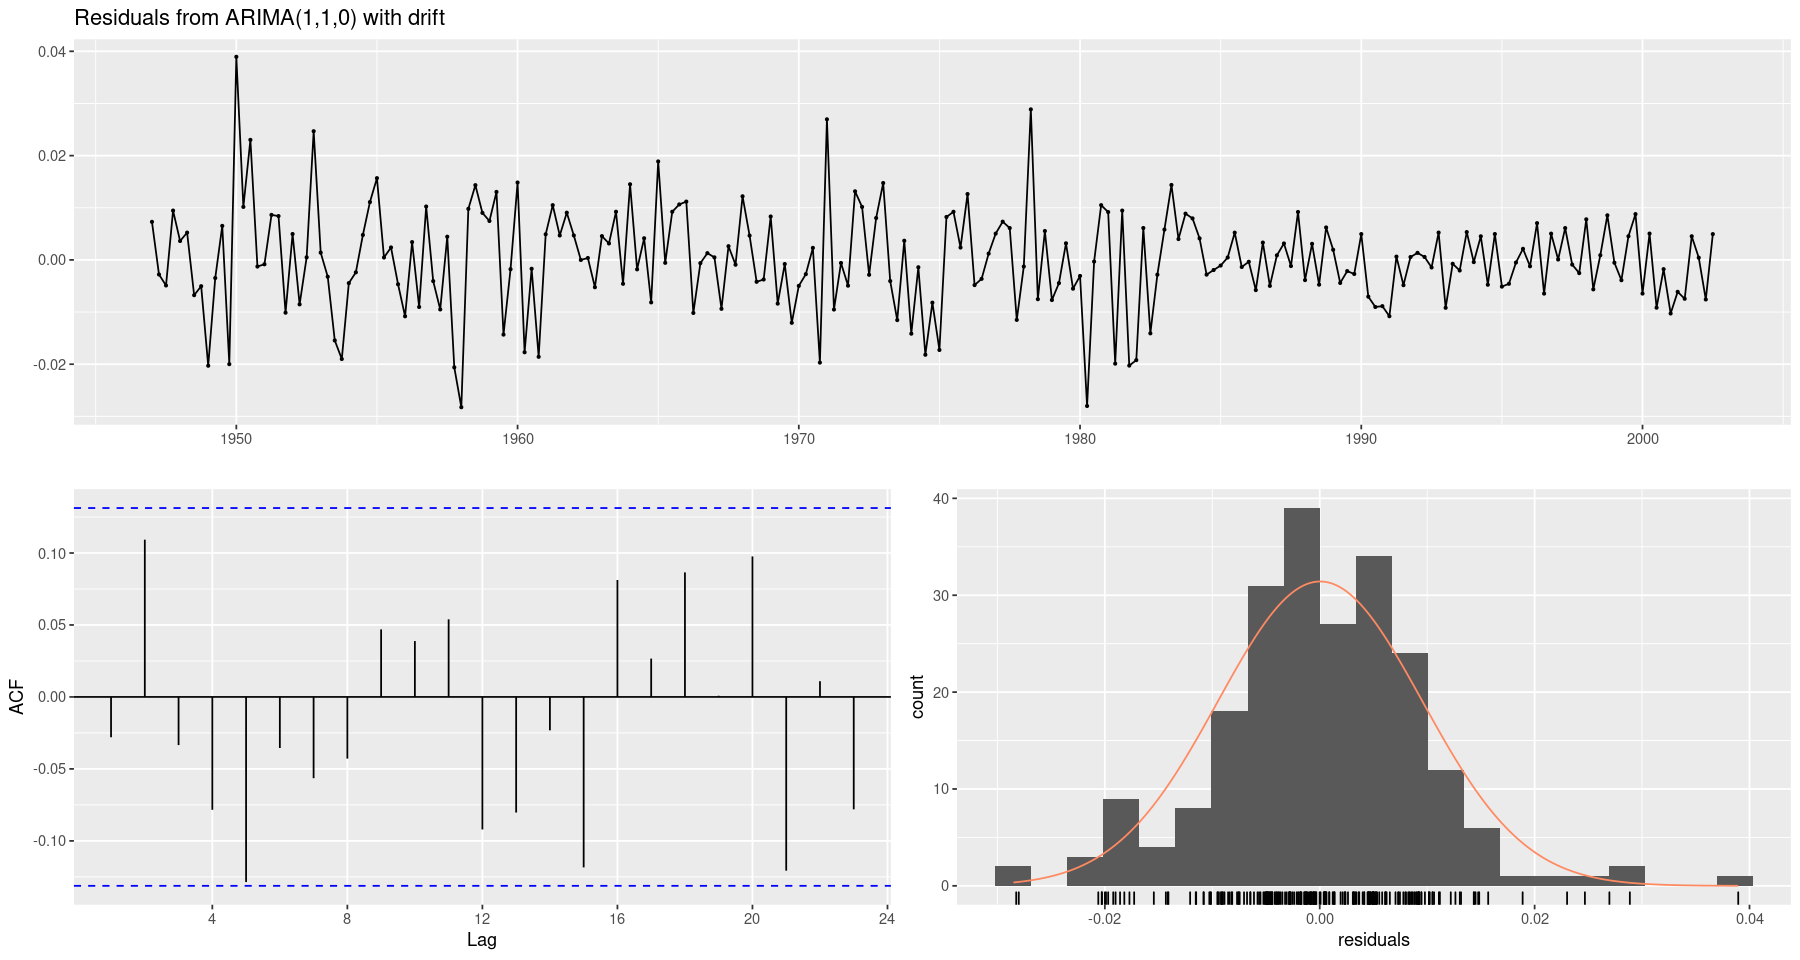

In [71]:
checkresiduals(fit)

In [72]:
#ARIMA(0,1,2)
fit2 = Arima(x,order=c(0,1,2), include.mean=FALSE, include.drift = TRUE)
fit2

Series: x 
ARIMA(0,1,2) with drift 

Coefficients:
         ma1     ma2   drift
      0.3028  0.2035  0.0083
s.e.  0.0654  0.0644  0.0010

sigma^2 estimated as 9.066e-05:  log likelihood=719.96
AIC=-1431.93   AICc=-1431.74   BIC=-1418.32

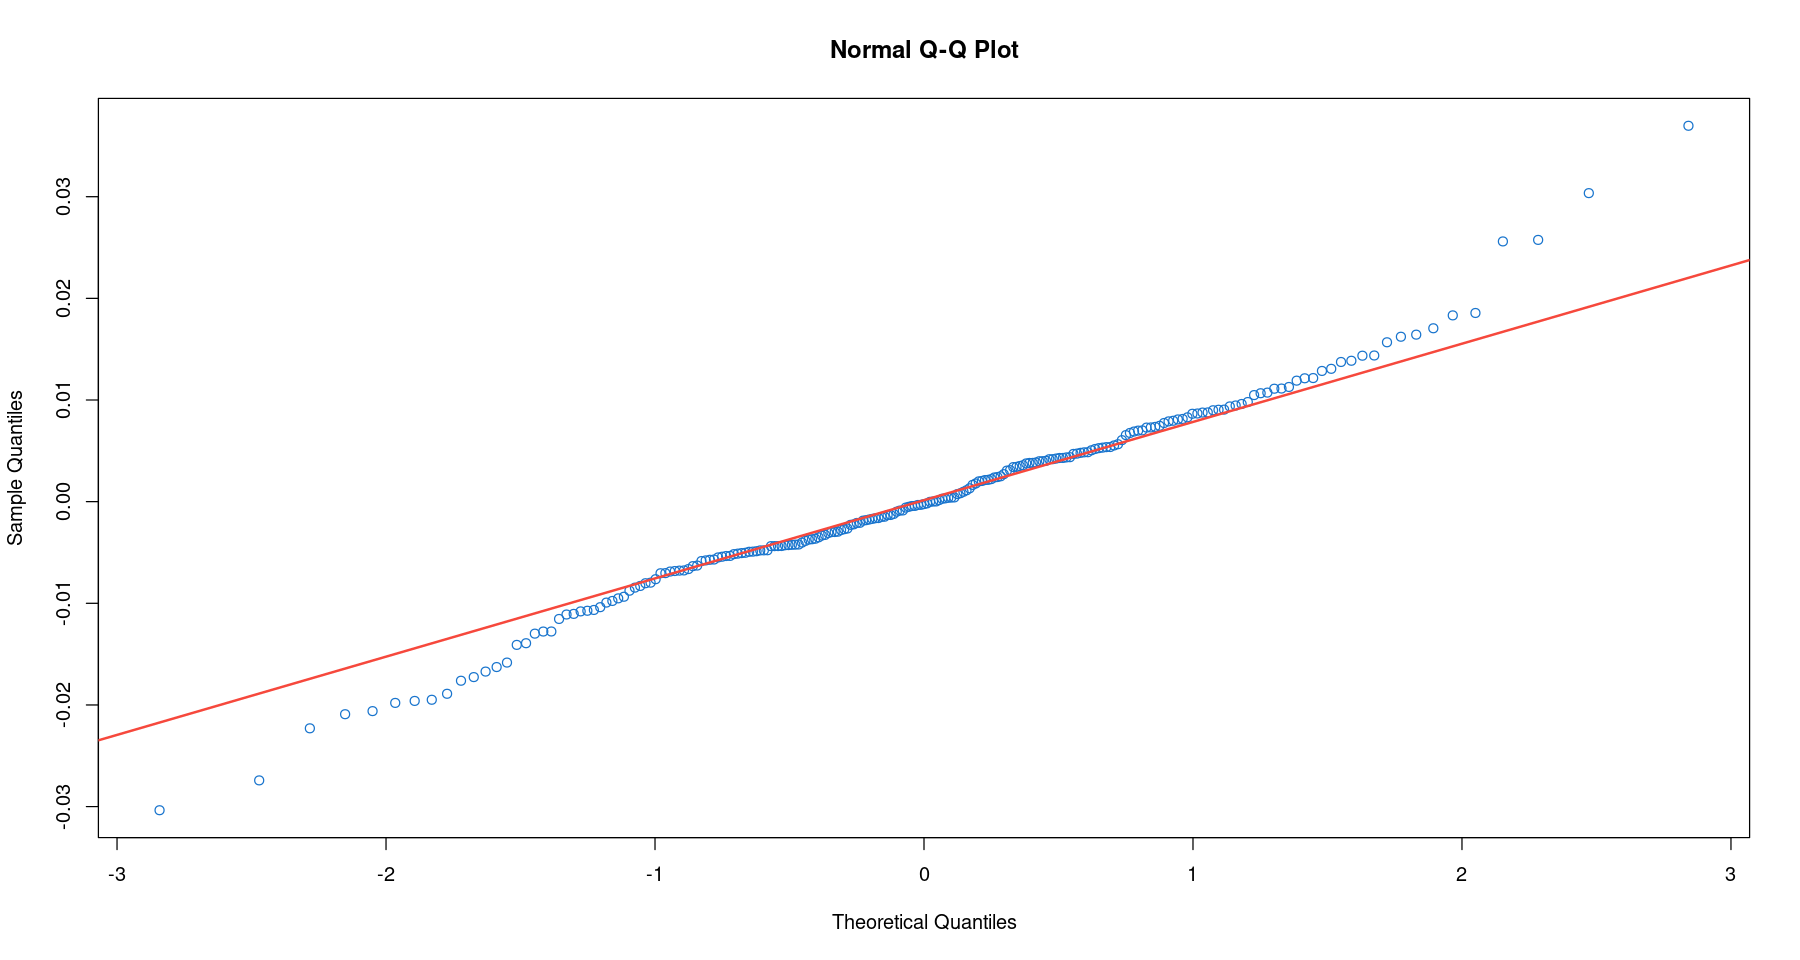

In [73]:
res2 = residuals(fit2)
qqnorm(res2, col=4)
qqline(res2, col=2, lwd=2)

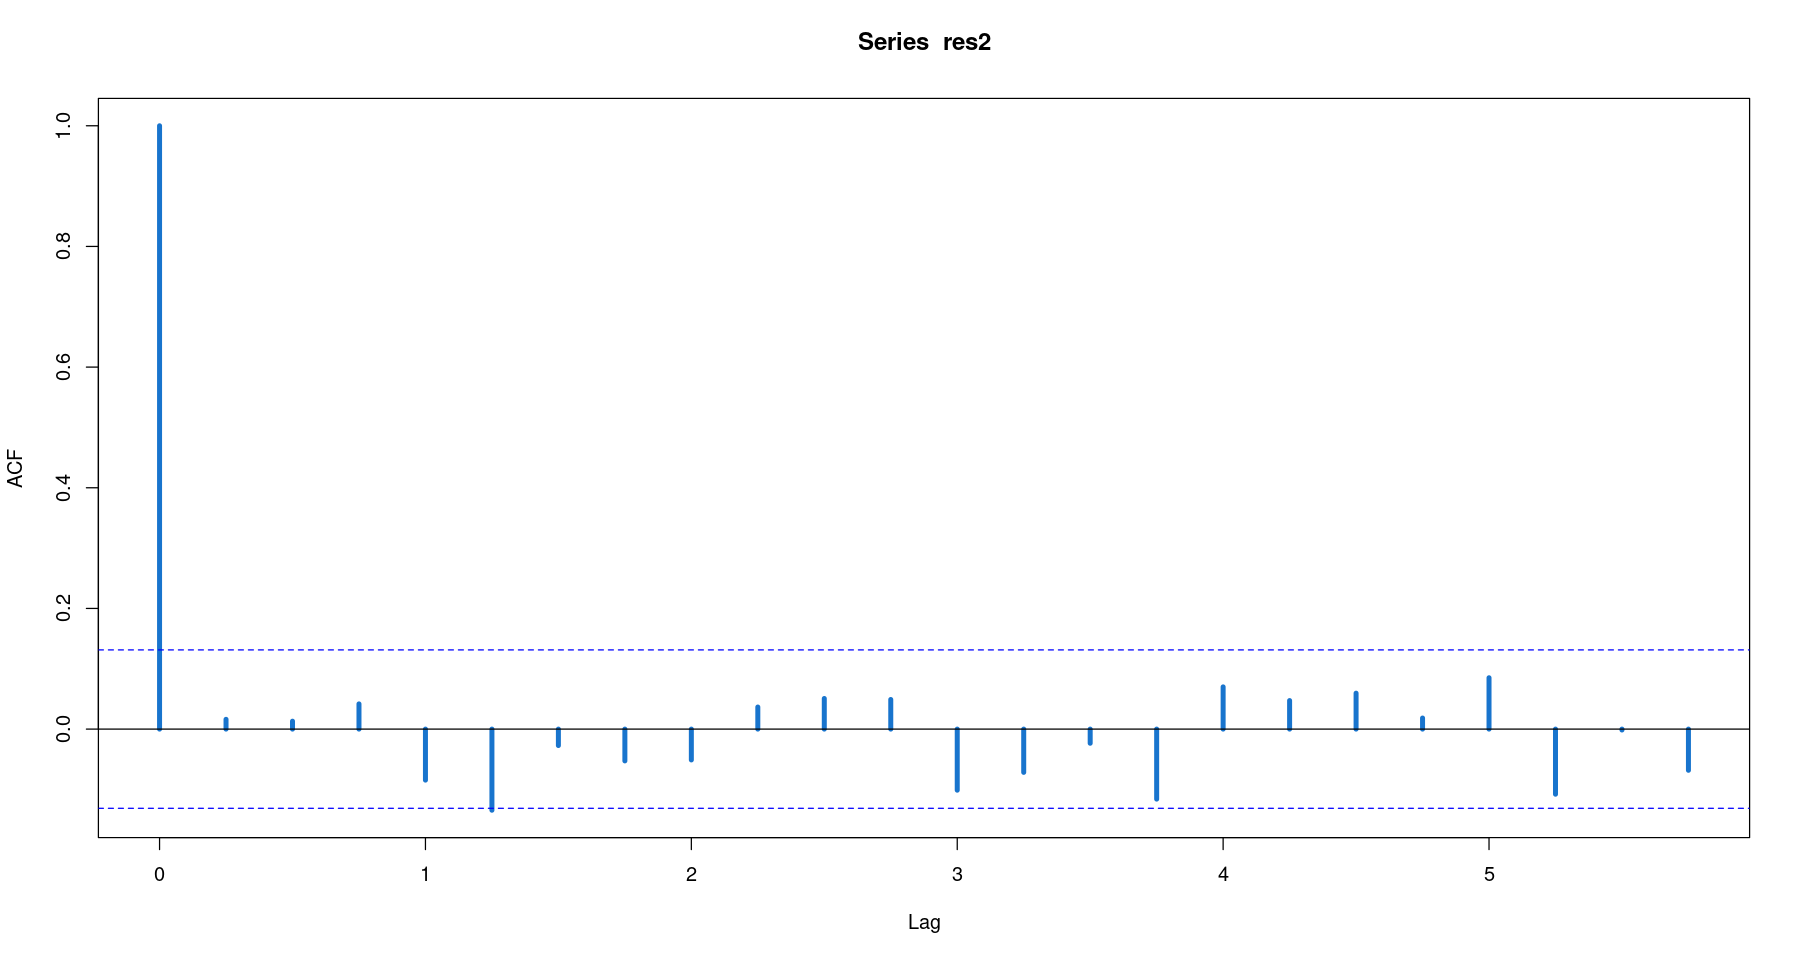

In [74]:
acf(res2, col=4, lwd=4)


	Ljung-Box test

data:  Residuals from ARIMA(0,1,2) with drift
Q* = 7.7205, df = 5, p-value = 0.1723

Model df: 3.   Total lags used: 8



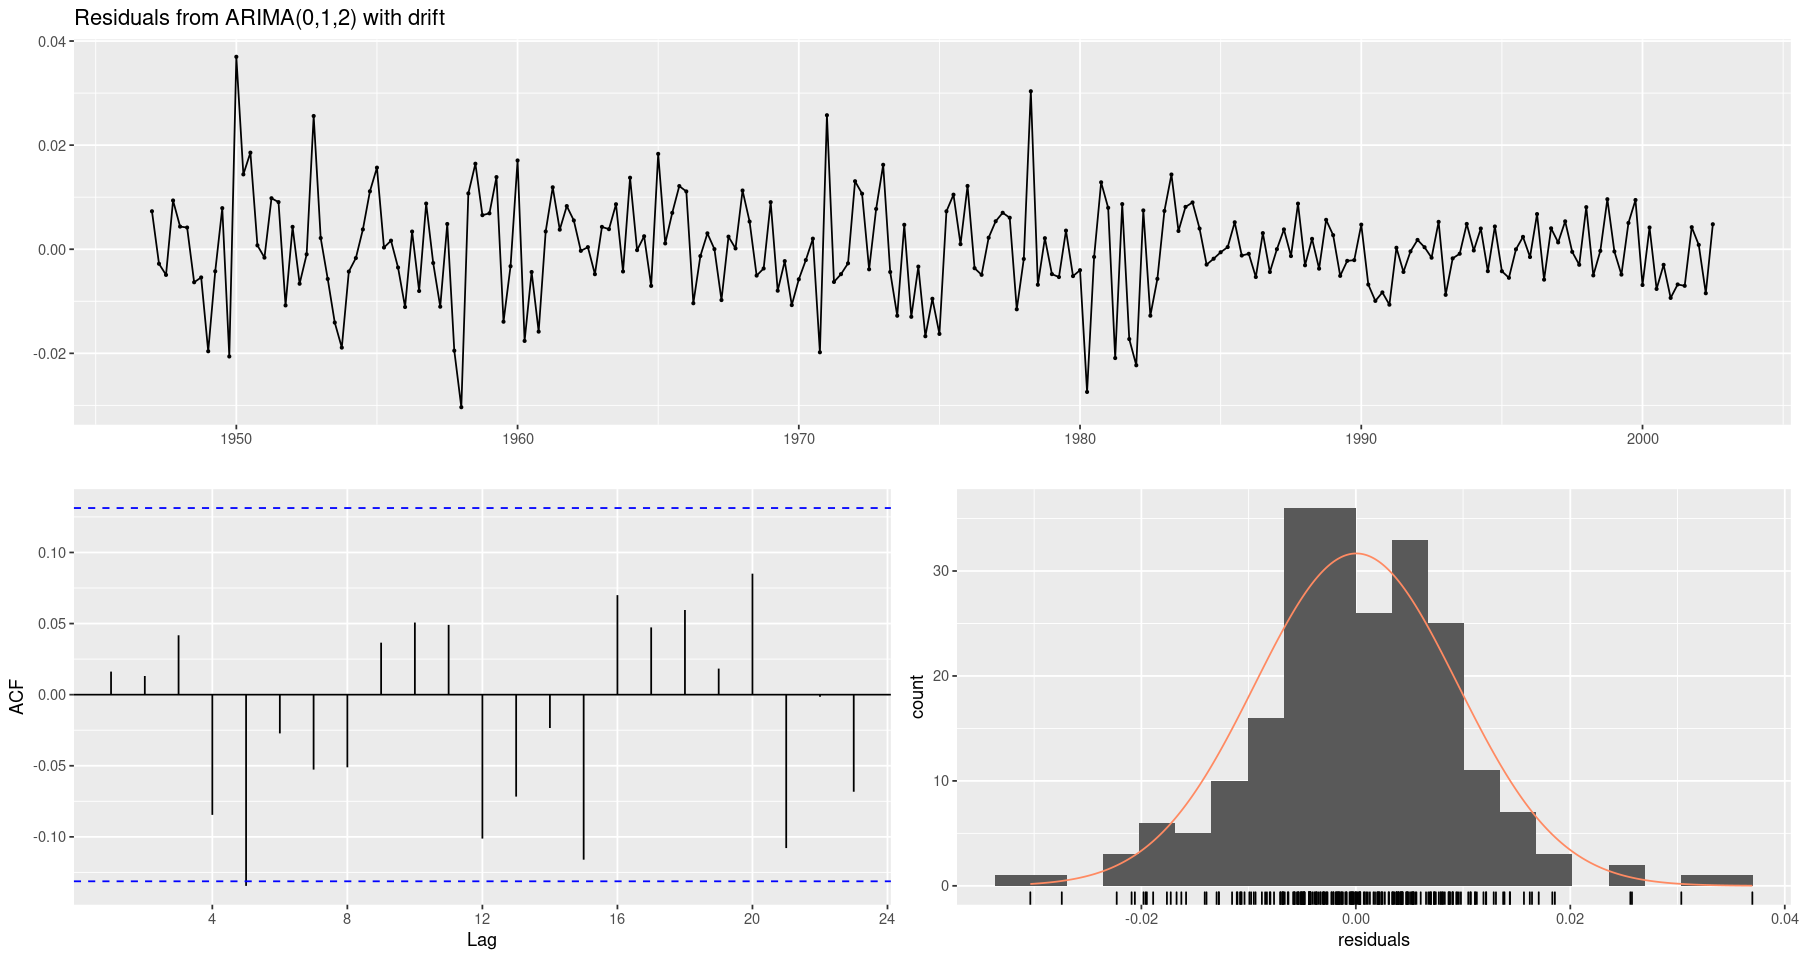

In [75]:
checkresiduals(fit2)

### Predicción:

Como último paso pasamos a la predicción a $10$ años:


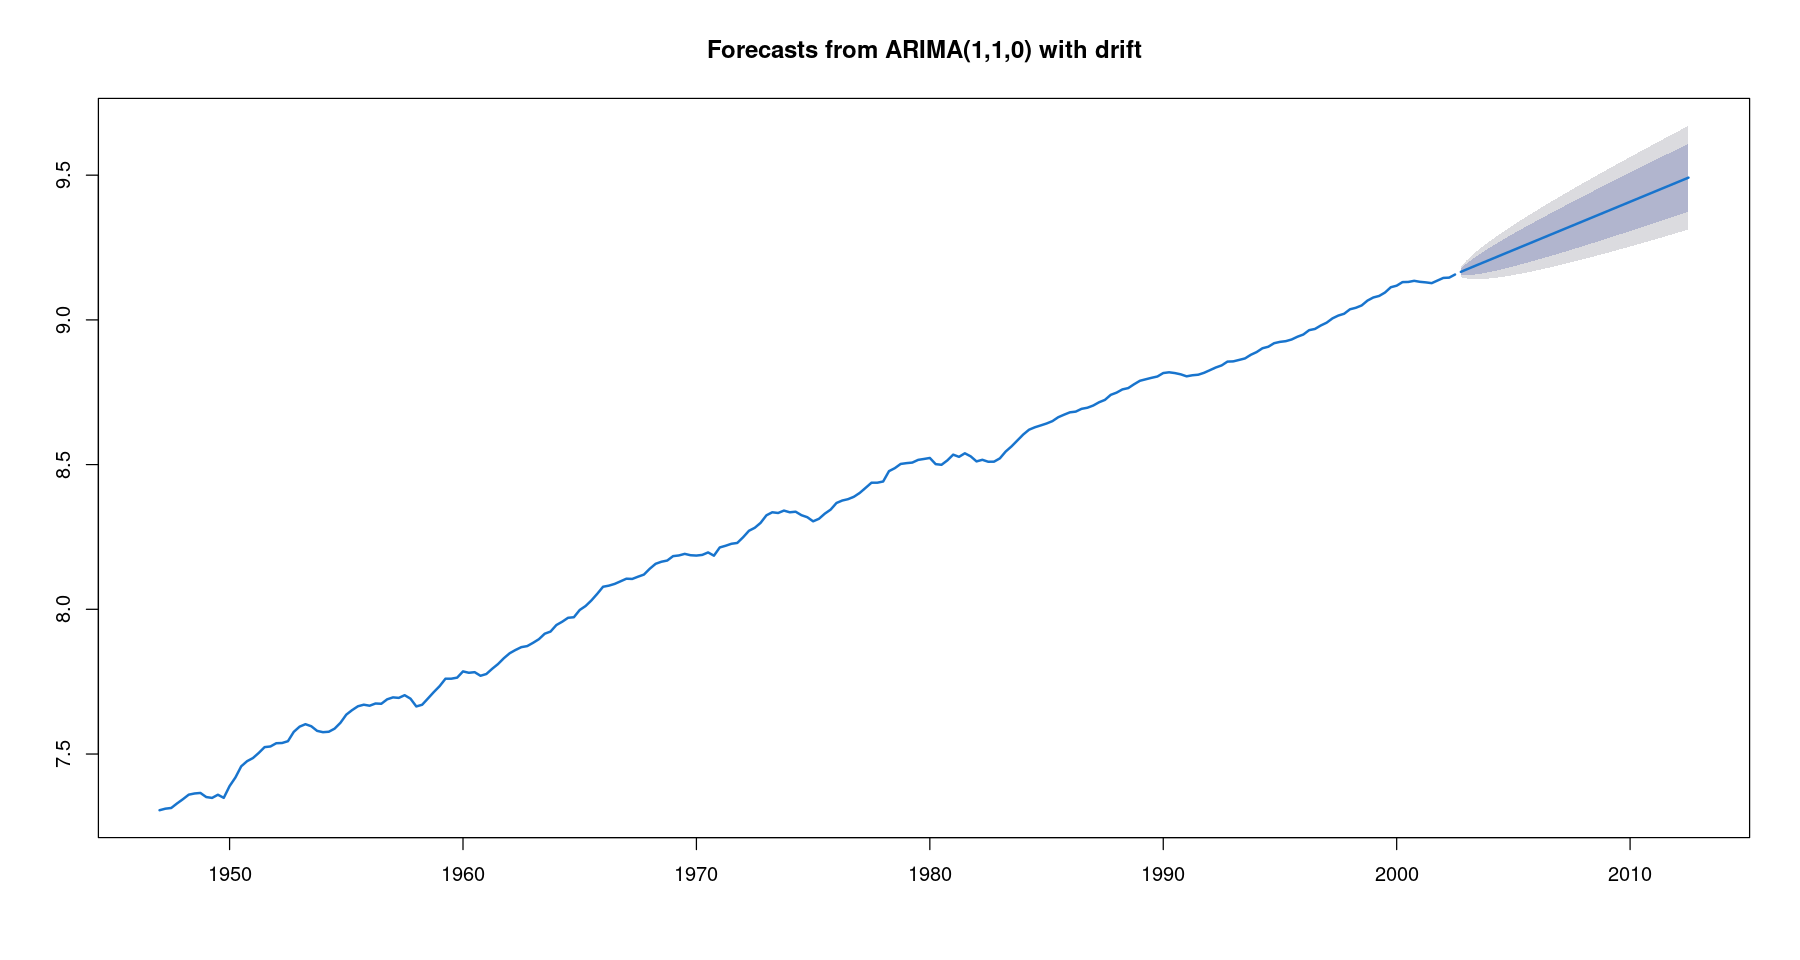

In [76]:
plot(forecast(fit,h=40), col=4, lwd=2)

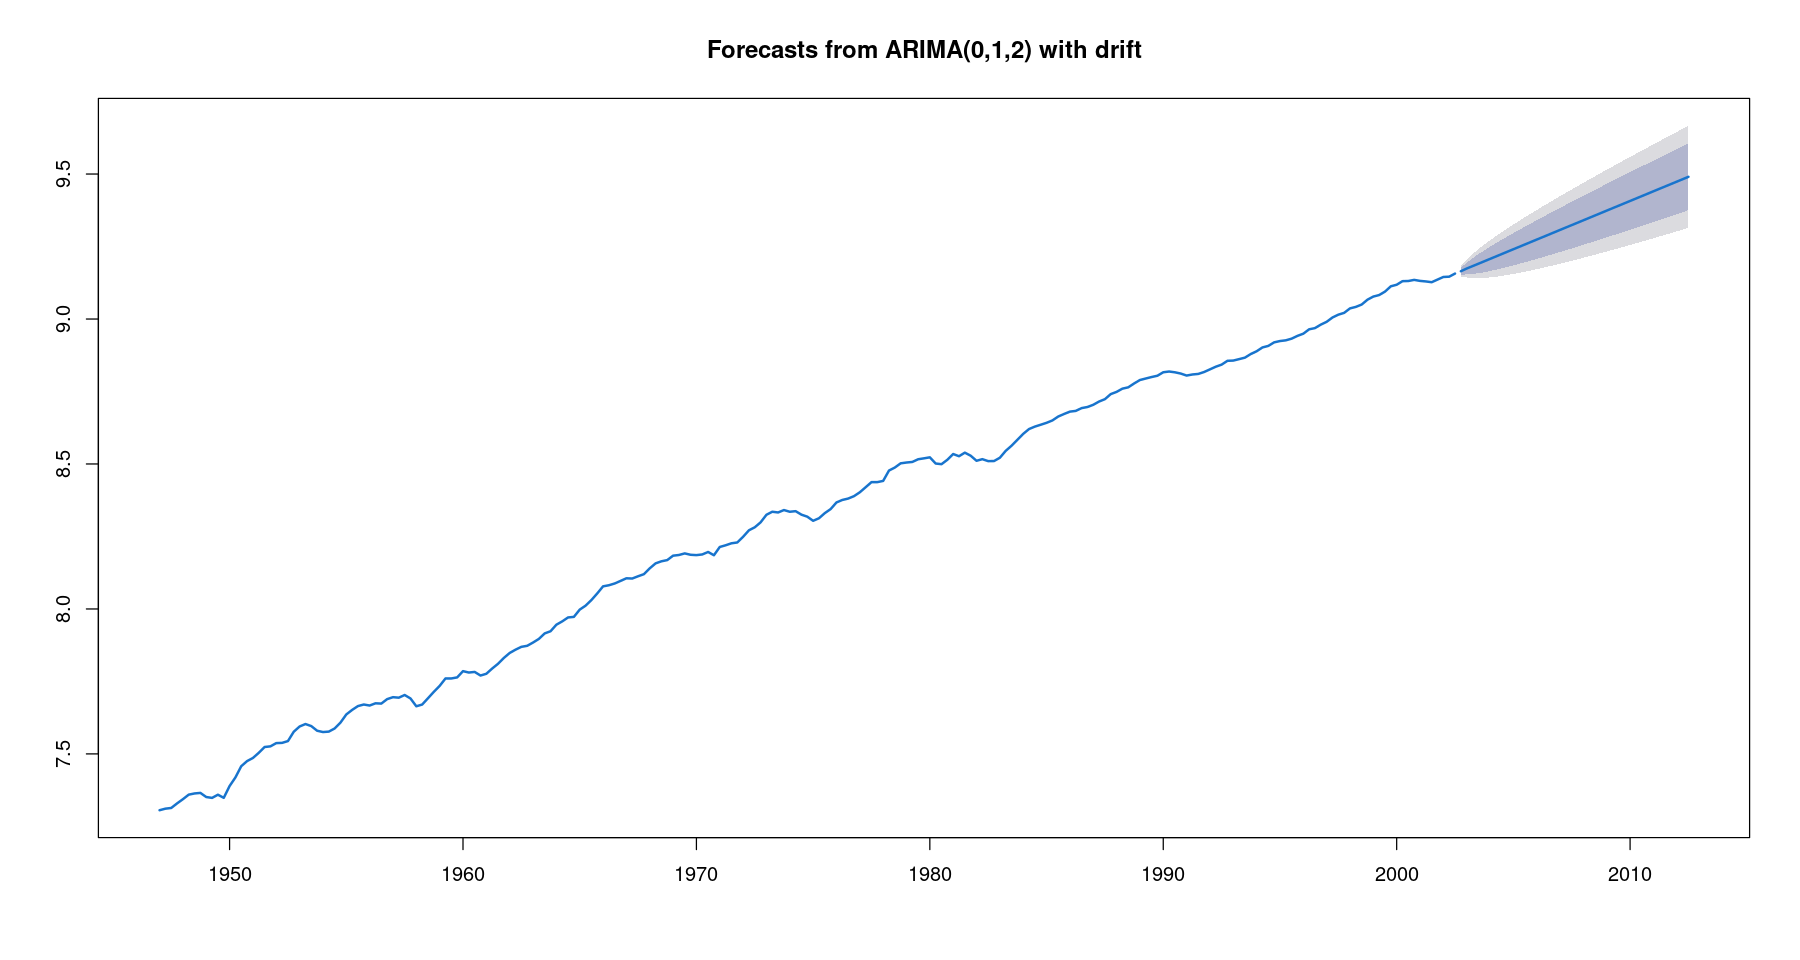

In [77]:
plot(forecast(fit2,h=40), col=4, lwd=2)

### ¿Por qué dan tan parecidos en este caso?

En realidad en este caso los dos modelos están bien, y son muy parecidos. Recordemos que un MA($q$) se puede pensar como un AR($\infty$). Se pueden calcular los coeficientes del mismo:

In [32]:
coef(fit)
coef(fit2)

ar1       drift 
0.346653556 0.008335952

ma1         ma2       drift 
0.302808644 0.203516088 0.008326694

In [33]:
ARMAtoMA(ar=.35, ma=0, 10)

[1] 3.500000e-01 1.225000e-01 4.287500e-02 1.500625e-02 5.252187e-03
 [6] 1.838266e-03 6.433930e-04 2.251875e-04 7.881564e-05 2.758547e-05

## Ejercicio

Correr todo el diagnóstico para la serie `varve` del ejercicio de la clase pasada.